# 投资时钟

In [1]:
#导入相关库
from WindPy import w
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import webbrowser
import statsmodels.api as sm
import scipy
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from scipy.optimize import brent, fmin, minimize
from scipy.signal import periodogram
from tqdm import trange
w.start()

24.2.0.60020
Wind.Cosmos.Base V1.7 compiled time is Apr 17 2023, BuildType:Release, CPUArch:X64, GCC Version:Apple LLVM 13.0.0 (clang-1300.0.29.30)
Welcome to use Wind Quant API for Python (WindPy)!

COPYRIGHT (C) 2021 WIND INFORMATION CO., LTD. ALL RIGHTS RESERVED.
IN NO CIRCUMSTANCE SHALL WIND BE RESPONSIBLE FOR ANY DAMAGES OR LOSSES CAUSED BY USING WIND QUANT API FOR Python.


.ErrorCode=0
.Data=[OK!]

In [2]:
beginning = '2008-01-31'
end = '2024-06-30'

# 数据处理函数

## 处理累计数据

In [3]:
def cumdata_clean(data):
    result,name,index,data = [],data.columns,data.index,data.iloc[:,0].tolist()
    for i in range(len(index)):
        if index[i].month == 2:
            result.append(data[i]/2)
            result.append(data[i]/2)
        elif index[i].month != 2:
            result.append(data[i] - data[i-1])
    return pd.DataFrame(result,index = pd.date_range(beginning,periods = len(result), freq='ME'),columns = name)

## 检查季节性

In [4]:
def check(data):
    result = []
    name = data.columns
    data = data.reset_index()
    data = data.dropna()
    data['month'] = data['date'].dt.month
    
    anova = [data[data['month'] == i].iloc[:, 1].tolist() for i in range(1, 13)]
    
    f, p_anova = scipy.stats.f_oneway(*anova)
    result.append([f, p_anova])
    
    h, p_kruskal = scipy.stats.kruskal(*anova)
    result.append([h, p_kruskal])
    
    result_df = pd.DataFrame(result, columns=['Test', 'p-value'], index=['ANOVA', 'Kruskal-Wallis'])
    return result_df


## HP滤波

In [5]:
def HP(data, lamb):
    N = len(data)
    if N <= 1:
        return data.copy()

    # Difference matrix
    D = np.zeros((N-2, N))
    for i in range(N-2):
        D[i, i] = 1
        D[i, i+1] = -2
        D[i, i+2] = 1

    # Identity matrix
    I = np.eye(N)

    # Calculate the inverse matrix
    inv_matrix = np.linalg.inv(I + lamb * D.T @ D)

    # Calculate trend component
    trend = inv_matrix @ data

    return trend

## 数据清理（去除周期性、HP滤波、换成同比）

In [6]:
def data_clean(data, name, seasonal, lamb):  
    data.columns = [name]

    if seasonal == 1:
        res = sm.tsa.seasonal_decompose(data, period=12, model="additive", extrapolate_trend='freq')
        data_compose = data.join([res.resid.rename('resid'), res.seasonal.rename('seasonal')])
        data_compose['T&C'] = data_compose[name] / (data_compose['resid'] * data_compose['seasonal'])
    else:
        data_compose = data.copy()
        data_compose['T&C'] = data_compose[name]
    
    # HP Filter
    trend_hp = HP(data_compose['T&C'], lamb)
    data_compose['trend_HP'] = trend_hp
    data_compose['Circle_HP'] = data_compose['T&C'] / data_compose['trend_HP']
    
    # Calculate percentage change
    data_compose['Circle_HP_pct'] = data_compose['Circle_HP'].pct_change(periods=12)  # Adjust the period if necessary
    
    return data_compose['Circle_HP_pct']


## 数据处理

In [7]:
ID_name_increase = ['产量:发电量', '产量:铝材', '产量:硫酸', '产量:空调', '产量:汽车', '销量:叉车:全行业', '货物周转量总计', '税收收入', '房地产开发投资完成额'] #'产量:乙烯', 
ID_code_increase = ['S0027012', 'S0027571', 'S0027103', 'S0028202', 'S0027907', 'S6001740', 'S0036018', 'M0024057', 'S0029656'] #'S0027159', 

ID_name_inflation = ['大宗价:猪肉', '螺纹价格指数', 'CRB油脂指数:', '原油期货','水泥指数']#,'矿价指数'] 
ID_code_inflation = ['S0066840', 'S0105916', 'S0031507', 'S0031525', 'S0105895']#,'S5042894'] 

ID_name_credit = ['M2', '金融机构贷款余额']#, '金融机构:企业存款余额']'社会融资规模', 
ID_code_credit = ['M0001384', 'M0009969']#, 'M0043410']'M5206730', 

ID_name_currency = ['R007','SHIBOR:3个月','USD/CNY']#,'成交量：银行间质押式回购']
ID_code_currency = ['M1001795','M0017142','USDCNY.FX']#,'M0041739']

lamb = 14400

In [8]:
def data_treatment(ID_code, ID_name):
    result = None
    for i in range(len(ID_code)):
        
        data = w.edb(ID_code[i], beginning, end, "Period=M;Days=Alldays", "Fill=Previous", usedf=True)[1]
        
        if ID_name == ID_name_increase:
            if i >= len(ID_code) - 2:
                data = cumdata_clean(data)
        
        data['date'] = pd.to_datetime(data.index)
        data.set_index('date', inplace=True)
        data = data.resample('ME').mean()
        data_index = data.index

        if ID_name != ID_name_currency:
            if check(data)['p-value'].mean() < 0.1:
                seasonal = 1
            else:
                seasonal = 0
            
            data = pd.DataFrame(data_clean(data.dropna(), ID_name[i], seasonal, lamb), index=data_index)
            data.columns = [ID_name[i]]
            data['date'] = pd.to_datetime(data.index)
            data.set_index('date', inplace=True)
        else:
            data = HP(data, 1)
            data.index = data_index
            data.columns = [ID_name[i]]
            
        # Replace NaN values with previous values
        data.ffill(inplace=True)
        data.fillna(0, inplace=True) 
        
        # Replace extreme values with previous values
        for j in range(1, len(data)):
            if data.iloc[j-1,0] != 0 and np.abs(data.iloc[j, 0]) > np.abs(data.iloc[j-1, 0]) * 80:
                data.iloc[j, 0] = data.iloc[j-1, 0]
        
        #print(data)
        
        if result is None:
            result = data
        else:
            result = result.join(data, how='left')
    
    return result


# 指标筛选

### 时差相关性

In [9]:
def replace_nan(lst):
    previous_value = None
    for i in range(len(lst)):
        if math.isnan(lst[i]) or lst[i] is None:
            if previous_value is not None:
                lst[i] = previous_value
            if i == 0 or previous_value is None:
                lst[i] = 0
        else:
            previous_value = lst[i]
        if math.isnan(lst[i]):
            print('nan found at index', i)
    return lst

In [10]:
def time_relation(index1, index2):
    ind1 = []
    ind2 = []
    L1 = [index1]
    L2 = [index2] 
    
    in1 = data_treatment(L1, [index1])
    in2 = data_treatment(L2, [index2])
    
    in1['date'] = pd.to_datetime(in1.index)
    in1.set_index('date', inplace=True)
    in2['date'] = pd.to_datetime(in2.index)
    in2.set_index('date', inplace=True)
    
    if len(in1) > len(in2):
        date_index = in2.index[12:-12]
    else:
        date_index = in1.index[12:-12]
    
    for i in range(len(date_index)):
        if date_index[i] in in1.index and date_index[i] in in2.index:
            ind1.append(in1.loc[date_index[i]].values[0])
            ind2.append(in2.loc[date_index[i]].values[0])
    
    index1 = ind1
    index2 = ind2
    
    # 定义延后和领先的期数
    leads = range(-11, 12)  # From -12 to 12 inclusive

    # 初始化最大和最小相关系数及对应的时差
    max_corr = -float('inf')
    min_corr = float('inf')
    selected_lead = 0  # Default value

    # 计算每个时差下的相关系数
    for lead in leads:
        lead_index1 = np.roll(index1, -lead)
        
        # Ensure the rolled data aligns with the comparison data
        if lead < 0:
            trimmed_index2 = index2[:lead]
            trimmed_lead_index1 = lead_index1[:lead]
        elif lead > 0:
            trimmed_index2 = index2[lead:]
            trimmed_lead_index1 = lead_index1[lead:]
        else:
            trimmed_index2 = index2
            trimmed_lead_index1 = lead_index1
        
        if len(trimmed_lead_index1) == 0 or len(trimmed_index2) == 0:
            continue
        
        if np.std(trimmed_lead_index1) == 0 or np.std(trimmed_index2) == 0:
            continue  # Skip if either array is constant

        corr, _ = pearsonr(trimmed_lead_index1, trimmed_index2)

        if corr > max_corr:
            max_corr = corr
            selected_lead = lead
        if corr < min_corr:
            min_corr = corr

        print(f"Correlation: {corr}, Lead: {lead}")
    
    # 输出结果
    if max_corr > 0:
        print("待考察指标的领先期数为:", selected_lead)
        print("最大相关系数为:", max_corr)
    else:
        print("待考察指标的滞后期数为:", selected_lead)
        print("最小相关系数为:", min_corr)
    
    lead_index = np.roll(index1, -selected_lead)
    lead_index_df = pd.DataFrame(lead_index, index=date_index)
    index2_df = pd.DataFrame(index2, index=date_index)

    graph(lead_index_df, index2_df)

def graph(lead_index, index2):
    plt.figure(figsize=(10, 6))
    plt.plot(lead_index, label='Lead Index')
    plt.plot(index2, label='Index 2')
    plt.legend()
    plt.title('Lead Index vs Index 2')
    plt.xlabel('Date')
    plt.ylabel('Values')
    plt.show()


In [11]:
#time_relation('M5206730','M0001382')

### K-L信息量

### 拐点匹配率

### 曲线形态匹配

# 增长因子

In [12]:
#ID_name_increase = ['产量:发电量', '产量:铝材', '产量:硫酸', '产量:乙烯', '产量:空调', '产量:汽车', '销量:叉车:全行业', '货物周转量总计', '税收收入', '房地产开发投资完成额'] #'房屋新开工面积', 
#ID_code_increase = ['S0027012', 'S0027571', 'S0027103', 'S0027159', 'S0028202', 'S0027907', 'S6001740', 'S0036018', 'M0024057', 'S0029656'] #'S0029669', 

## 基准指标PMI

In [13]:
data_raw = w.edb('M0017126', beginning, end, "Fill=Previous", usedf=True)[1]
#print(data_raw)

PMI = ((data_raw - 50) / 100 + 1).cumprod()
PMI_cleaned = data_clean(PMI, 'PMI', 0, lamb)
PMI = pd.DataFrame({'PMI': PMI_cleaned}, columns=['PMI'])
#print(PMI)

In [14]:
"""
data = w.edb('M0017126', beginning, end, "Fill=Previous", usedf=True)[1]
plt.figure(figsize=(10, 6))
plt.plot(data, label='PMI')
plt.legend()
"""

'\ndata = w.edb(\'M0017126\', beginning, end, "Fill=Previous", usedf=True)[1]\nplt.figure(figsize=(10, 6))\nplt.plot(data, label=\'PMI\')\nplt.legend()\n'

## 合成

In [15]:
result = data_treatment(ID_code_increase, ID_name_increase)
#print(result)

In [16]:
#OECD法合成指标 (Organisation for Economic Co-operation and Development)
def OECD(result_):
    SDj = abs(result_ - result_.mean()).sum()/result_.shape[0]
    SCj = (result_ - result_.mean())/SDj
    return SCj.T.sum()

In [17]:
#合成指标
result_ = result.iloc[12:,:]
S= OECD(result_)
X = PMI.iloc[12:,]
k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
d = X.mean()[0] - S.mean()
CI_increase = k * S + d
#print(CI_increase)

/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/3924616338.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/3924616338.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = X.mean()[0] - S.mean()


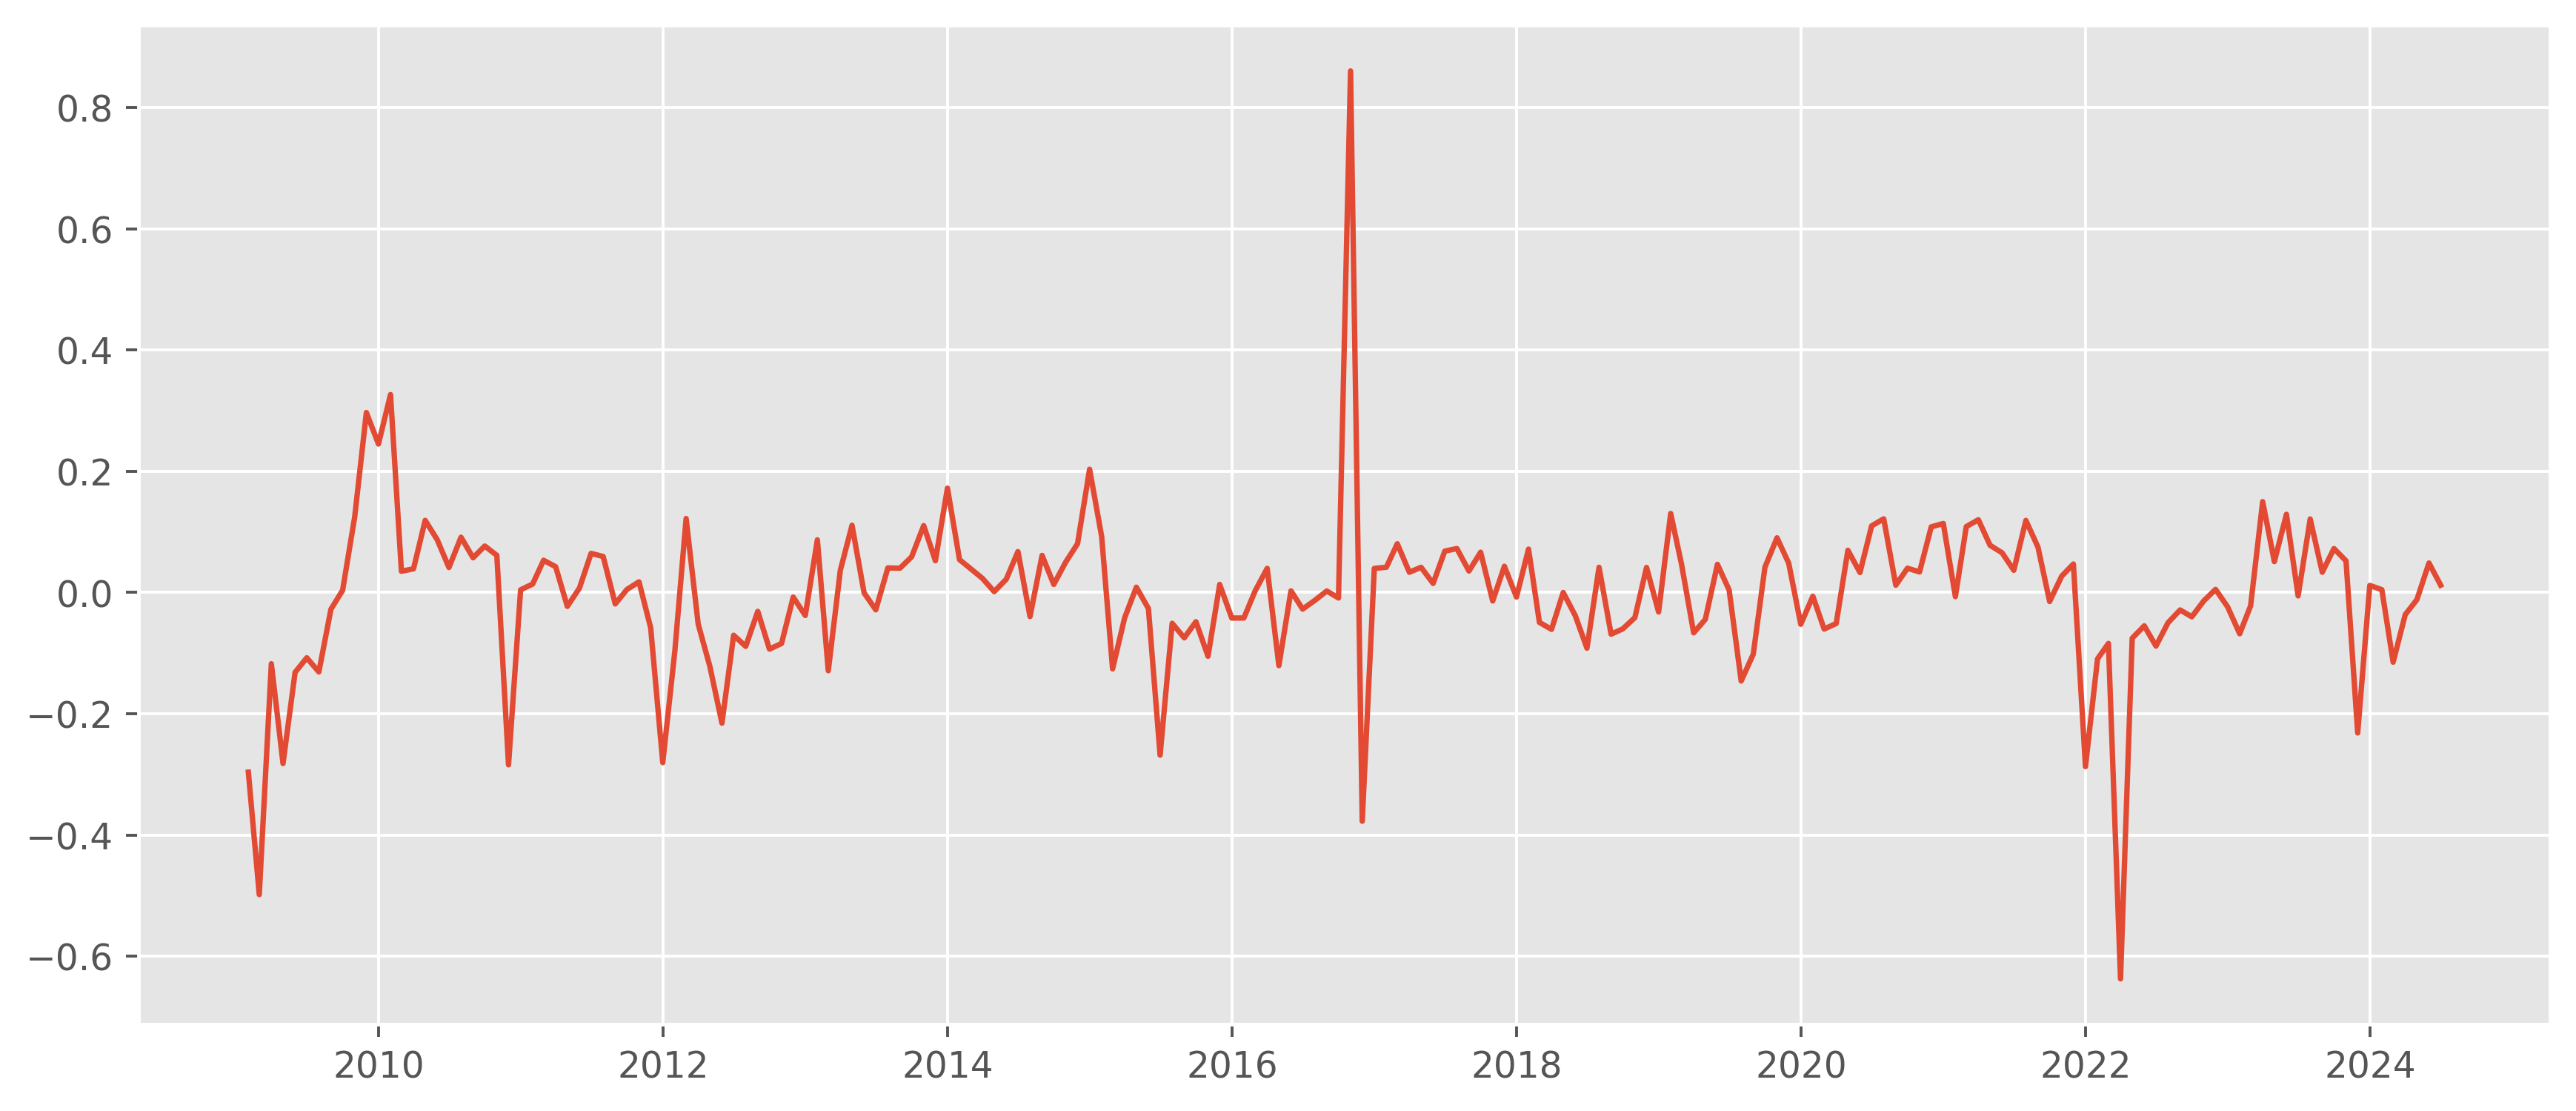

In [18]:
plt.style.use('ggplot')
plt.figure(figsize=(12,5),dpi = 350)
plt.plot(CI_increase,label = 'increase')

# 通胀因子

In [19]:
#ID_code_inflation = ['S0066840', 'S0031507', 'S0031525'] #'S5711190',   , 'S5705040'
#ID_name_inflation = ['大宗价:猪肉', 'CRB 现货指数:油脂', '期货结算价:布伦特原油'] #'螺纹价格指数',    , 'MyIpic 矿价指数:综合'

## 基准指标 CPI&PPI

In [20]:
CPI = w.edb('M0000705',beginning,end,"Period=M;Days=Alldays", "Fill=Previous",usedf = True)[1]
PPI = w.edb('M0049160',beginning,end,"Period=M;Days=Alldays", "Fill=Previous",usedf = True)[1]

CPI = (CPI/100 + 1).cumprod()
PPI = (PPI/100 + 1).cumprod()

CPI_weight = 1/CPI.std() / (1/CPI.std() + 1/PPI.std())
PPI_weight = 1/PPI.std() / (1/CPI.std() + 1/PPI.std())

inflation = CPI*CPI_weight + PPI*PPI_weight
inflation = data_clean(inflation.dropna(),'inflation',0,lamb)
inflation = pd.DataFrame(inflation)
#inflation = inflation.pct_change(periods = 12)
inflation.columns = ['inflation']

## 合成

In [21]:
#通胀相关指标处理
result = data_treatment(ID_code_inflation, ID_name_inflation)
#print(result)

In [22]:
result_ = result.iloc[12:,:]

In [23]:
#OECD法合成指标
S= OECD(result_)
X = inflation.iloc[12:,]
k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
d = X.mean()[0] - S.mean()
CI_inflation = k * S + d

/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/4230063680.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/4230063680.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = X.mean()[0] - S.mean()


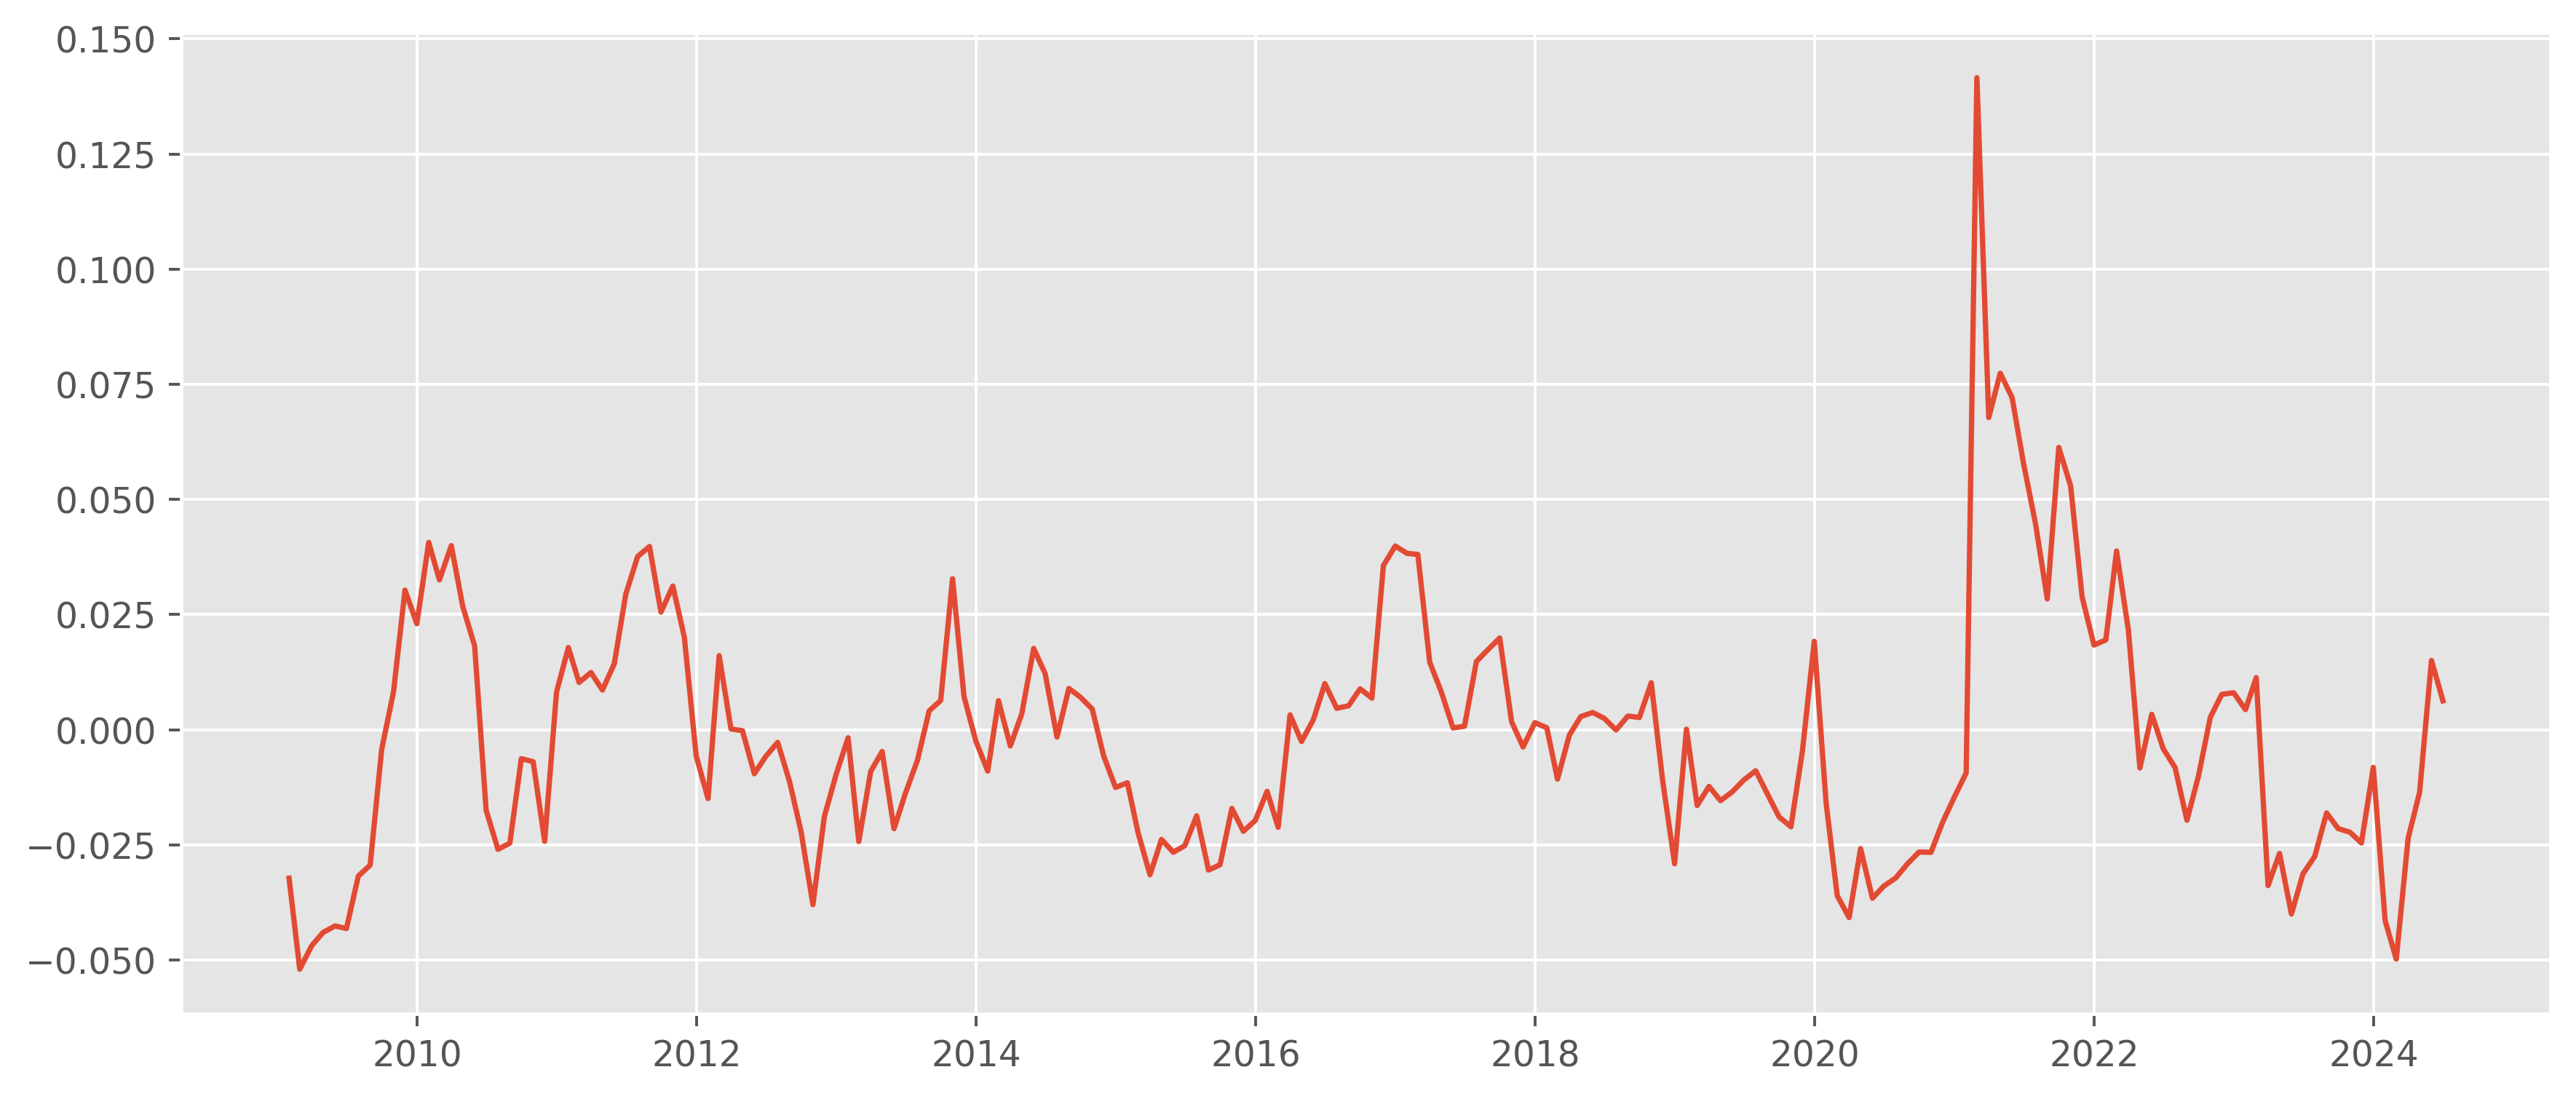

In [24]:
plt.figure(figsize=(12,5),dpi = 350)
plt.plot(CI_inflation,label = 'inflation')

# 信用因子

In [25]:
#ID_name_credit = ['M2', '社会融资规模:当月值', '金融机构:各项贷款余额', '金融机构:企业存款余额']
#ID_code_credit = ['M0001384', 'M5206730', 'M0009969', 'M0043410']

## 基准指标 M1-PPI

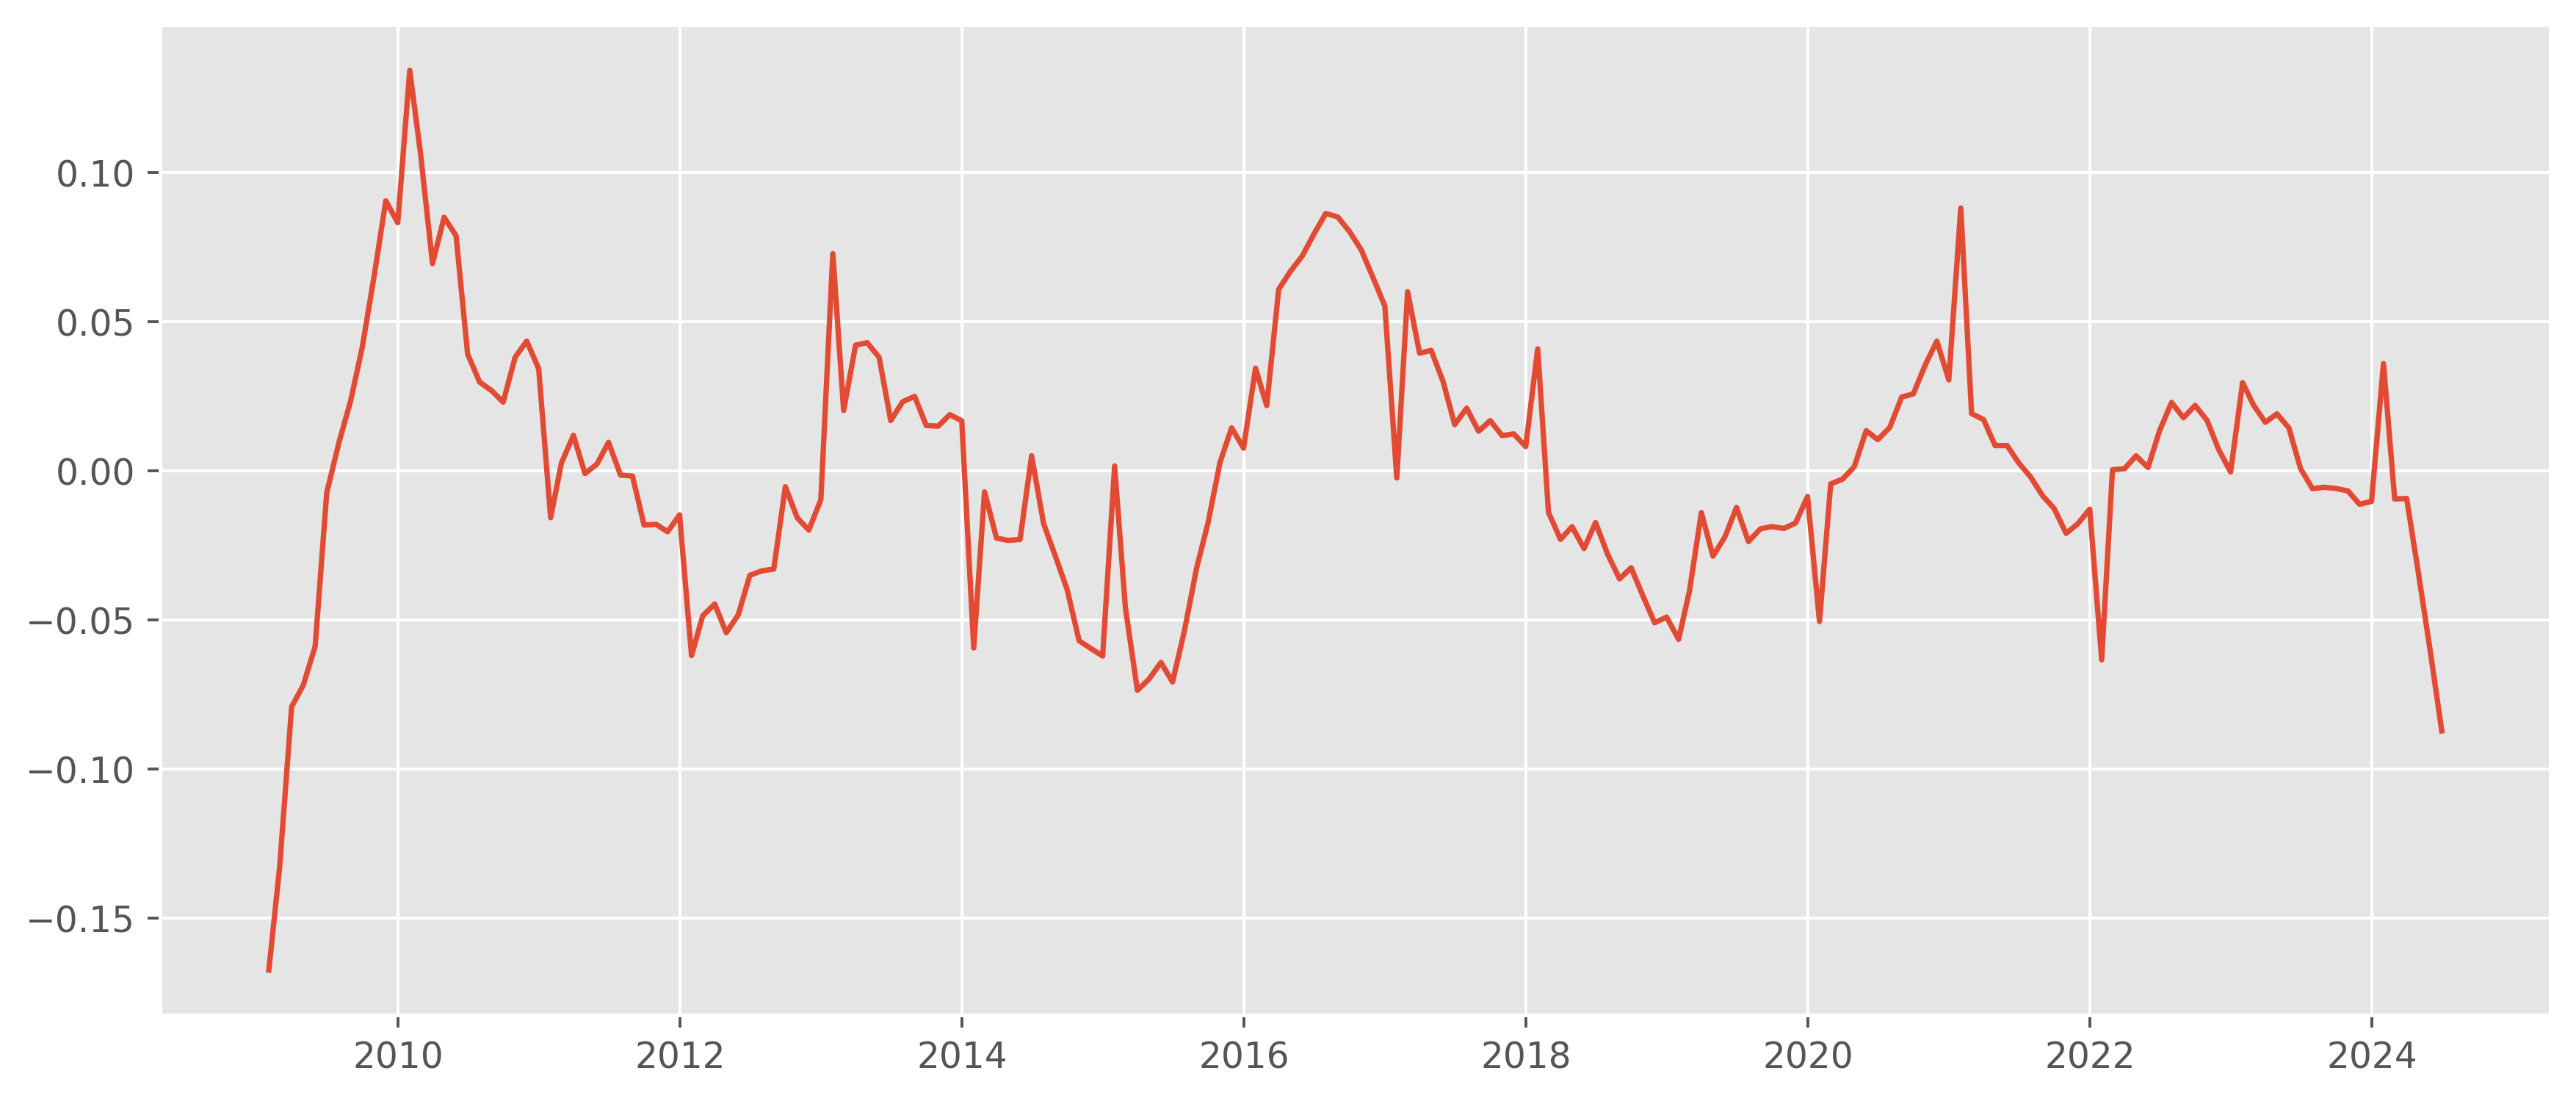

In [26]:
M1 = w.edb('M0001382',beginning,end,"Period=M;Days=Alldays", "Fill=Previous",usedf = True)[1]
PPI = w.edb('M0049160',beginning,end,"Period=M;Days=Alldays", "Fill=Previous",usedf = True)[1]

PPI = (PPI/100 + 1).cumprod()

credit = M1 
credit = data_clean(credit.dropna(),'credit',0,lamb)
credit = pd.DataFrame(credit)
credit.columns = ['credit']
date_index1 = credit.index
#print(credit)
#credit = credit.pct_change(periods = 12)
plt.figure(figsize=(12,5),dpi = 350)
plt.plot(credit)

## 合成

In [27]:
#信用相关指标处理
result = data_treatment(ID_code_credit, ID_name_credit)

In [28]:
result_ = result.iloc[12:,:]

In [29]:
#OECD法合成指标
S= OECD(result_)
X = credit.iloc[12:,]
k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
d = X.mean()[0] - S.mean()
CI_credit = k * S + d

/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/918120212.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/918120212.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = X.mean()[0] - S.mean()


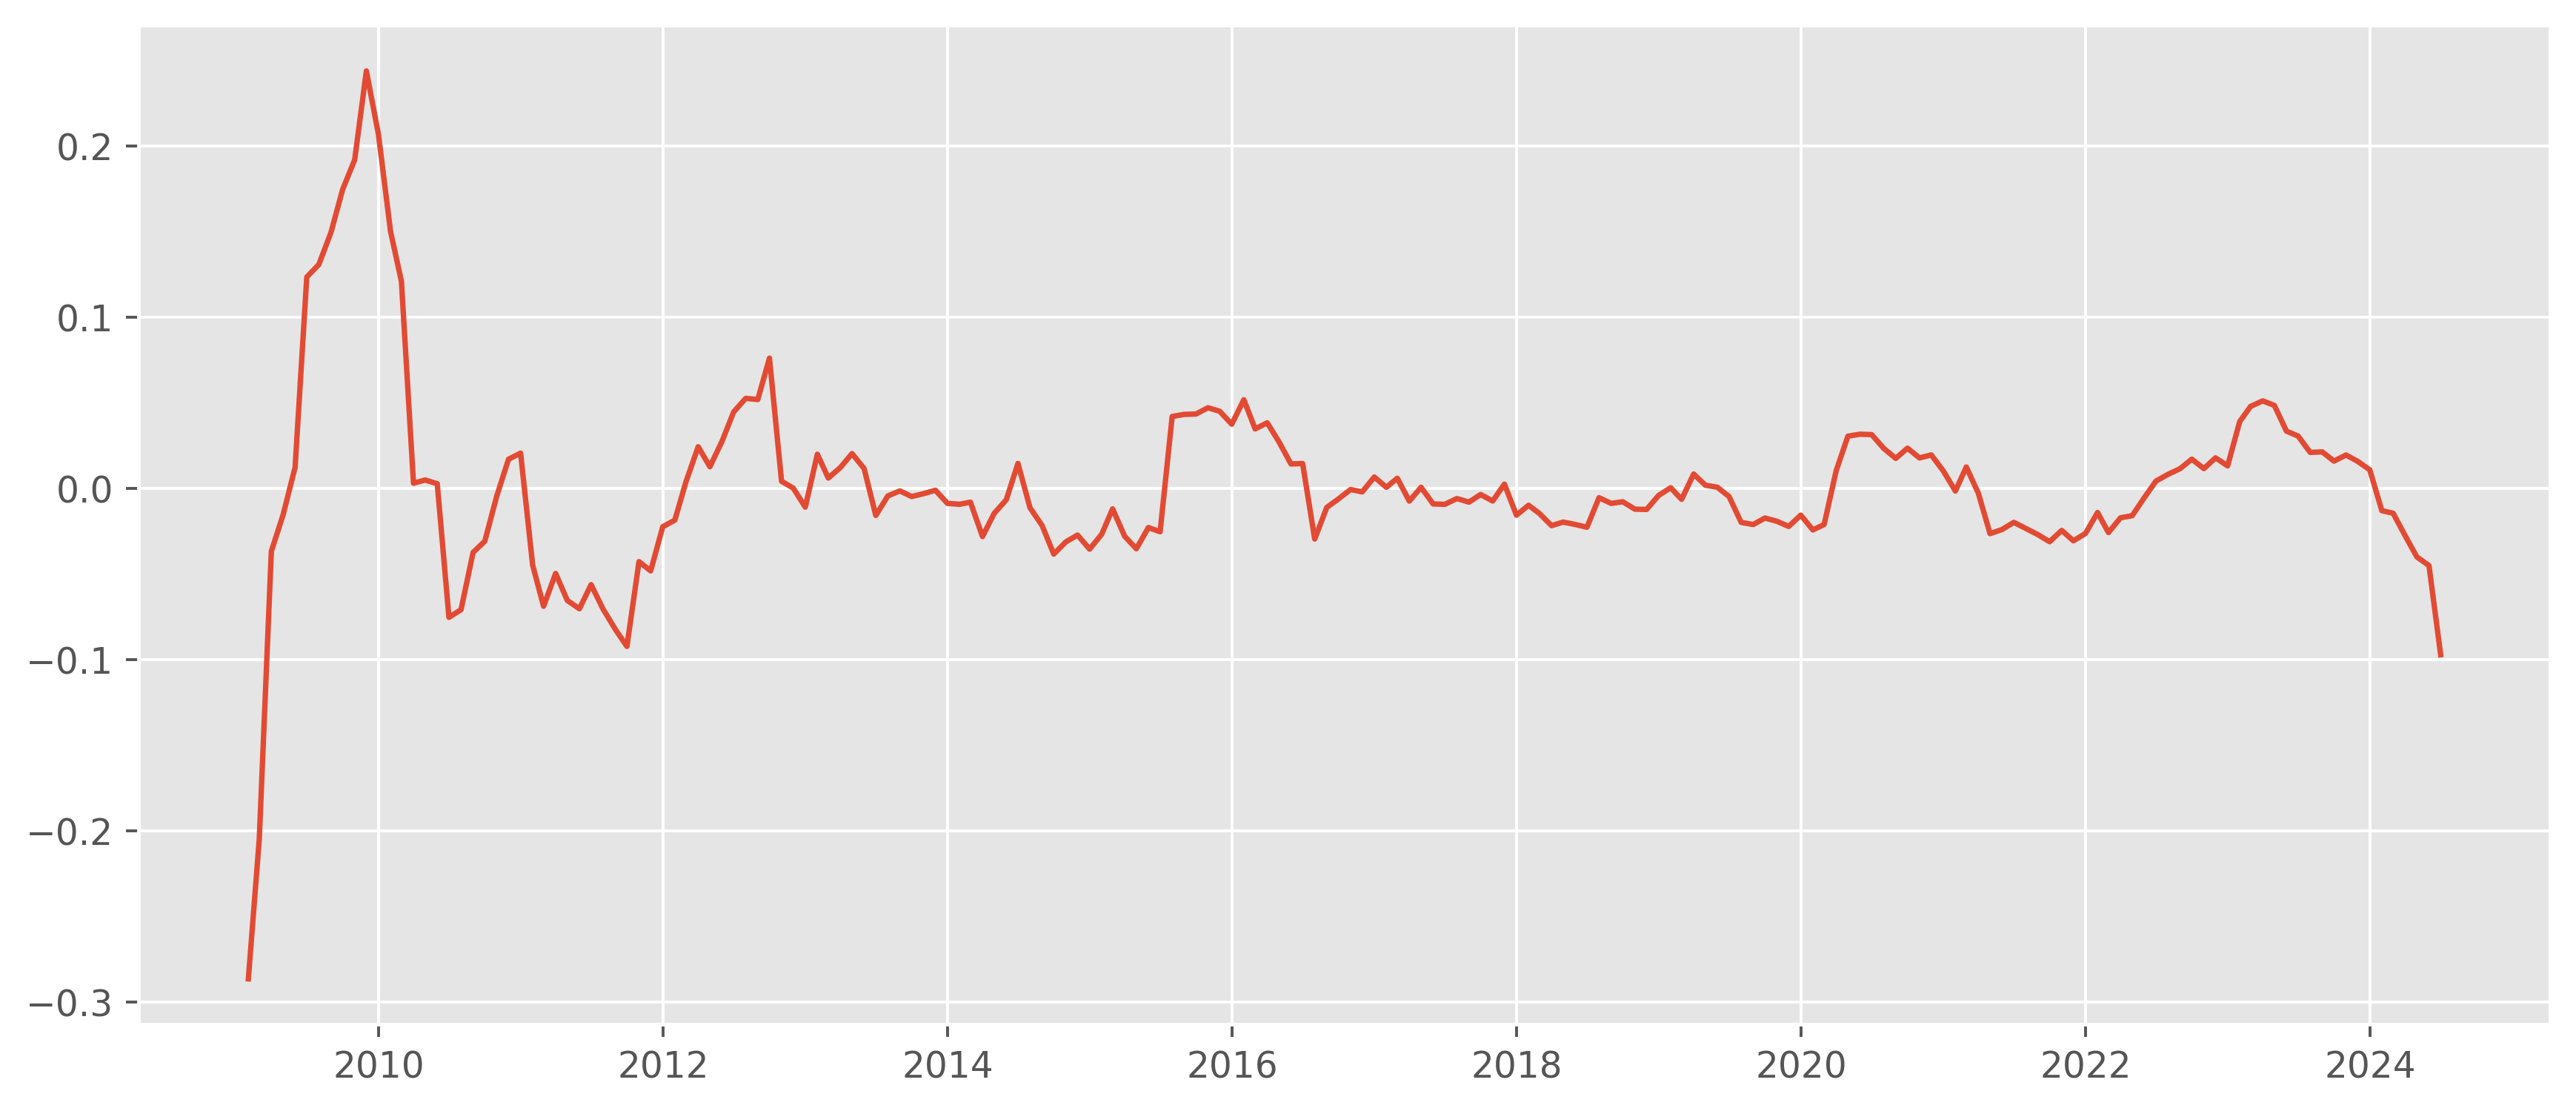

In [30]:
plt.figure(figsize=(12,5),dpi = 350)
plt.plot(CI_credit)

# 货币因子

In [31]:
#ID_code_currency = ['M1001795','M0017142','M0041739'] #'M0220163', 
#ID_name_currency = ['R007','SHIBOR:3个月','成交量：银行间质押式回购'] #'DR007',

## 基准指标 一年期国债

In [32]:
#货币相关指标处理
CGB1 = w.edb('S0059744',beginning,end,"Period=M;Days=Alldays","Fill=Previous",usedf = True)[1]
#CGB10 = w.edb('S0059749',beginning,end,"Period=M;Days=Alldays","Fill=Previous",usedf = True)[1]

currency = CGB1
currency = data_clean(currency.dropna(),'currency',0,lamb)
currency = pd.DataFrame(currency)
currency.columns = ['currency']
#print(currency)

## 合成

In [33]:
result = data_treatment(ID_code_currency, ID_name_currency)
#print(result)

In [34]:
result_ = result.iloc[12:,1:]

In [35]:
#OECD法合成指标
S= OECD(result_)
X = currency.iloc[12:,]
k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
d = X.mean()[0] - S.mean()
CI_currency = k * S + d

/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/3640760860.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  k = abs(X - X.mean()).sum()[0]/abs(S - S.mean()).sum()
/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/3640760860.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  d = X.mean()[0] - S.mean()


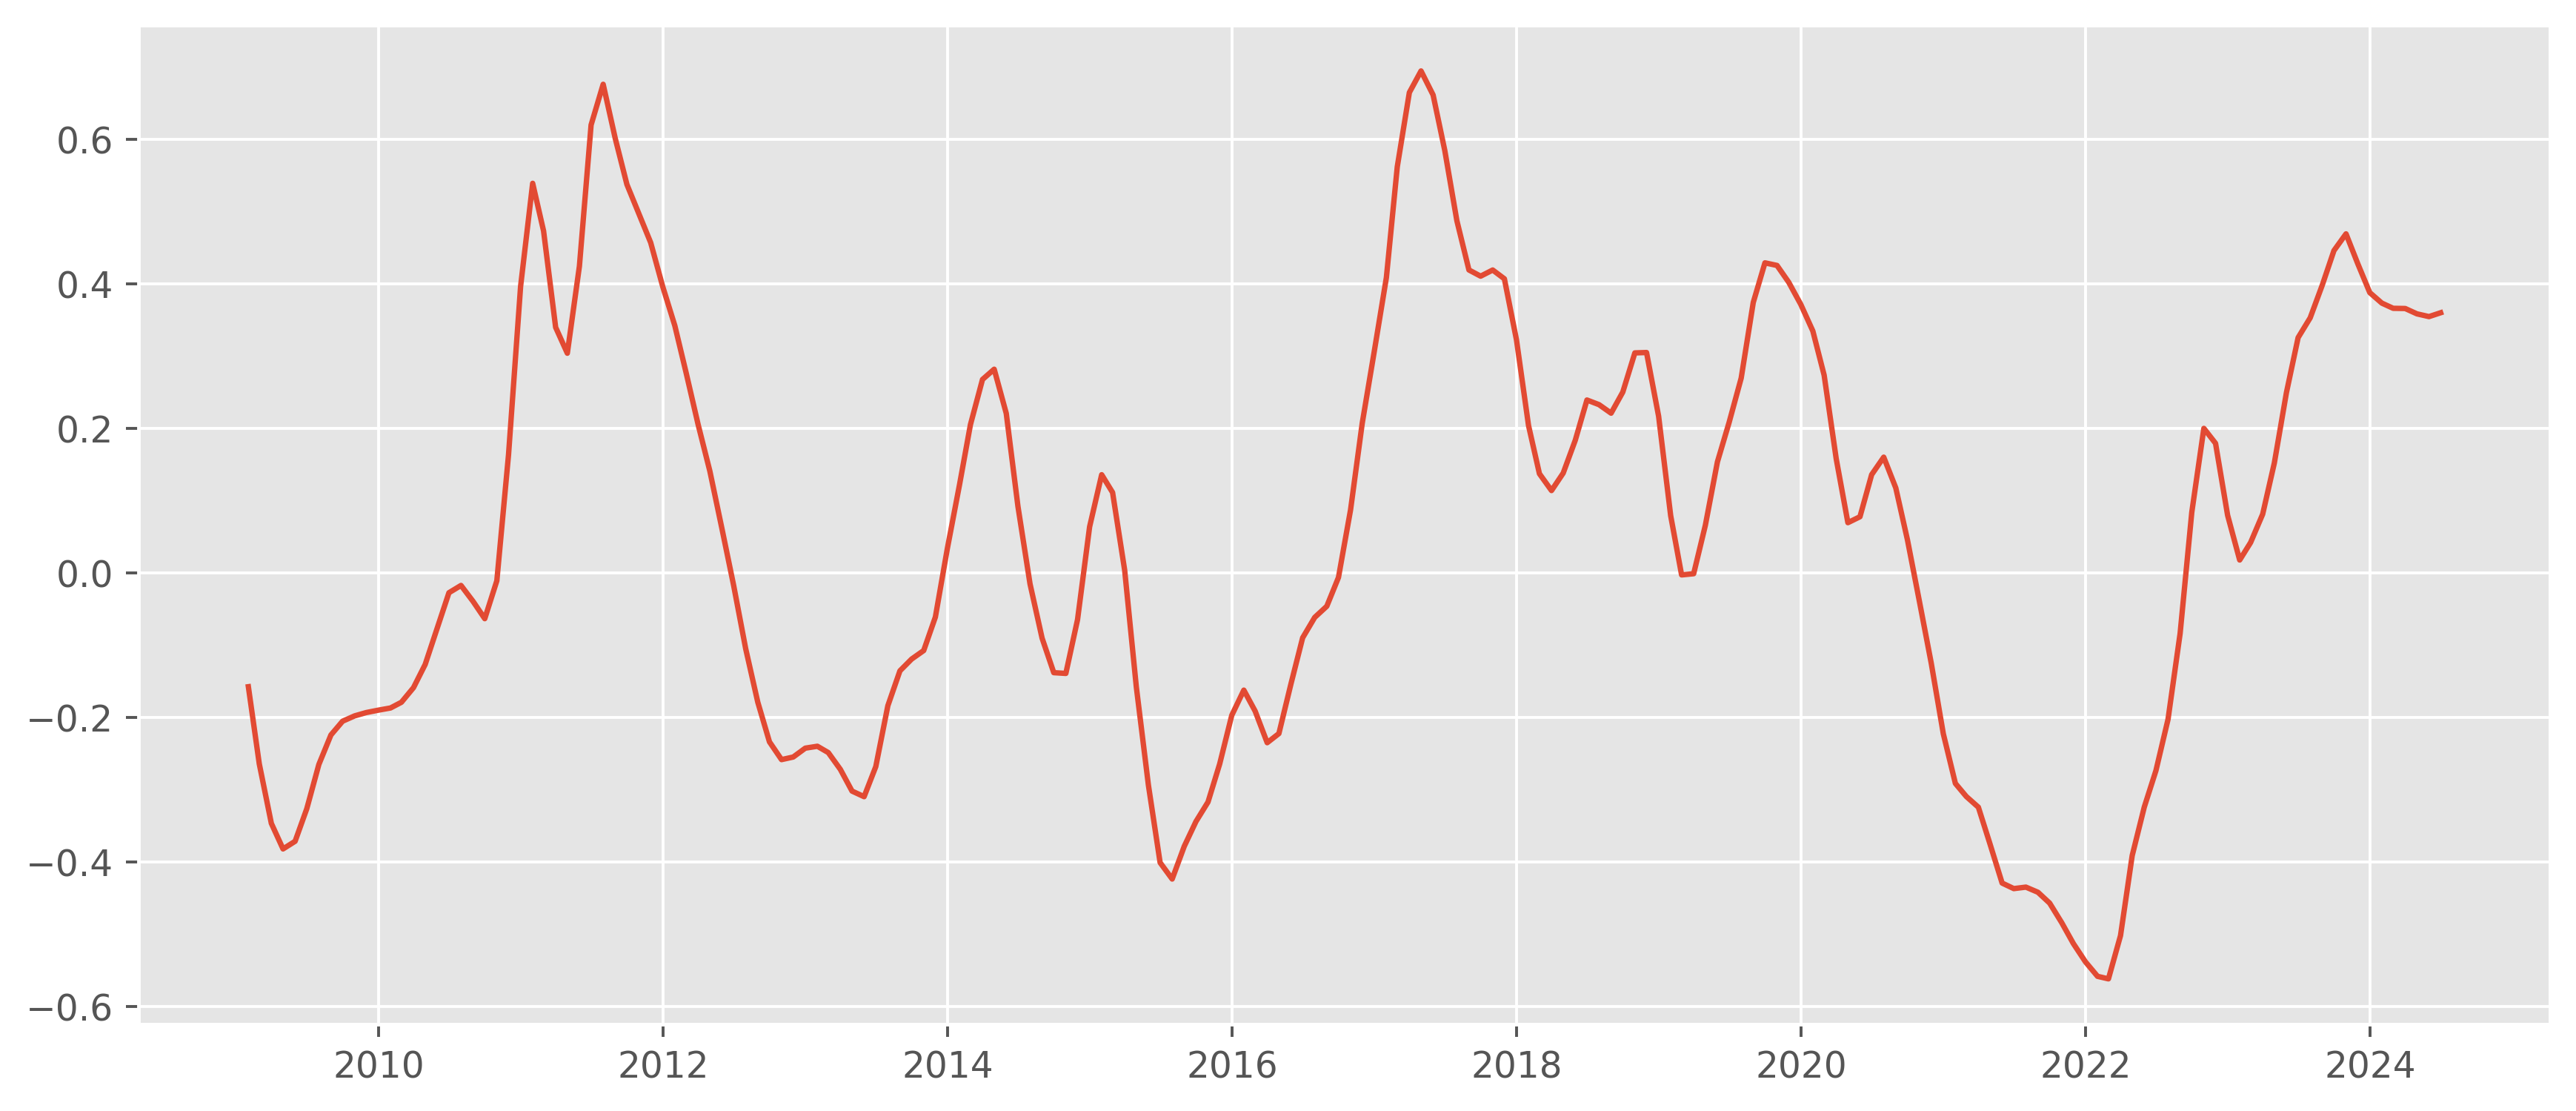

In [36]:
plt.figure(figsize=(12,5),dpi = 350)
plt.plot(CI_currency)

# 宏观-资产映射

In [37]:
def backtest(df,time1,time2,name):
    for i in range(len(time1)):
        df1 = df[(df['date']>pd.to_datetime(time1[i][0])) & (df['date']<pd.to_datetime(time1[i][1]))]
        df2 = df[(df['date']>pd.to_datetime(time2[i][0])) & (df['date']<pd.to_datetime(time2[i][1]))]
        if i == 0:
            df_up,df_down = df1,df2
        elif i != 0:
            df_up,df_down = pd.concat([df_up,df1]),pd.concat([df_down,df2])     
                  
    stock,bond,commodit,gold = [df_up['stock'].mean(),df_down['stock'].mean()],[df_up['bond'].mean(),df_down['bond'].mean()],[df_up['commodit'].mean(),df_down['commodit'].mean()],[df_up['gold'].mean(),df_down['gold'].mean()]
    
    df_result = pd.DataFrame([stock,bond,commodit,gold])
    df_result.index,df_result.columns = ['stock','bond','commodit','gold'],[name + ' up',name + ' down']
    return df_result

In [38]:
macro_fac = pd.DataFrame([CI_increase,CI_inflation,CI_credit,CI_currency]).T
macro_fac.columns = ['increase','inflation','credit','currency']
#print(macro_fac)

In [39]:
stock = w.wsd("881001.WI", "close", beginning, end, "Period=M;Days=Alldays",usedf = True)[1].pct_change(periods = 1).dropna()
stock.columns = ['stock']

bond = w.wsd("CBA00101.CS", "close", beginning, end, "Period=M;Days=Alldays",usedf = True)[1].pct_change(periods = 1).dropna()
bond.columns = ['bond']

commodit = w.wsd("NH0100.NHF", "close", beginning, end, "Period=M;Days=Alldays",usedf = True)[1].pct_change(periods = 1).dropna()
commodit.columns = ['commodit']

gold = w.wsd("AU9999.SGE", "close", beginning, end, "Period=M;Days=Alldays",usedf = True)[1].pct_change(periods = 1).dropna()
gold.columns = ['gold']

In [40]:
df = pd.concat([macro_fac, stock, bond, commodit, gold], axis=1).dropna()
df['date'] = pd.to_datetime(df.index)
#print(df)

In [41]:
increase_time1 = [('2009/2/28','2010/8/31'),('2012/5/31','2013/11/30'),('2015/8/31','2017/5/31'),('2019/4/30','2020/8/31')] #,('2022/5/31','2023/9/30')] # 
increase_time2 = [('2010/10/31','2012/5/31'),('2014/1/31','2015/6/30'),('2017/5/31','2018/8/31'),('2020/11/30','2022/3/31')]

inflation_time1 = [('2009/2/28','2010/5/31'),('2012/10/31','2014/5/31'),('2016/2/29','2017/9/30'),('2020/3/31','2021/2/28')]
inflation_time2 = [('2011/1/31','2012/10/31'),('2014/5/31','2015/8/31'),('2017/9/30','2019/10/31'),('2021/2/28','2023/5/31')]

credit_time1 = [('2009/1/31','2009/11/30'),('2011/9/30','2013/2/28'),('2014/12/31','2016/6/30'),('2017/12/31','2019/4/30')]
credit_time2 = [('2009/11/30','2011/9/30'),('2013/2/28','2014/3/31'),('2016/6/30','2017/12/31'),('2020/4/30','2021/9/30')]

currency_time1 = [('2009/4/30','2011/7/31'),('2015/7/31','2018/9/30'),('2022/2/28','2023/10/31')] #('2013/5/31','2014/4/30'),
currency_time2 = [('2011/7/31','2013/5/31'), ('2014/4/30','2015/7/31'),('2018/10/31','2022/2/28')]


In [42]:
df1 = backtest(df, increase_time1, increase_time2, 'Increase')
df2 = backtest(df, inflation_time1, inflation_time2, 'Inflation')
df3 = backtest(df, credit_time1, credit_time2, 'Credit')
df4 = backtest(df, currency_time1, currency_time2, 'Currency')

In [43]:
#不同经济环境下资产收益率情况
pd.concat([df1,df2,df3,df4],axis = 1)*100

,Increase up,Increase down,Inflation up,Inflation down,Credit up,Credit down,Currency up,Currency down
stock,1.299360,1.362609,2.065787,0.528139,1.440978,0.537698,0.046416,1.827341
bond,0.227699,0.475803,0.143939,0.440933,0.451768,0.108375,0.248160,0.470926
commodit,1.034646,0.575051,1.661266,-0.057383,0.575991,1.030482,1.246725,0.080241
gold,1.010367,0.273750,0.203625,0.652825,0.593904,0.309237,1.057074,0.201762


# 宏观点位预测

In [44]:
def calculate_period_power(data, period):
    """Calculate the power of a given period in the data."""
    n = len(data)
    frequency = 1 / period
    t = np.arange(n)
    sin_wave = np.sin(2 * np.pi * frequency * t)
    cos_wave = np.cos(2 * np.pi * frequency * t)
    sin_coefficient = np.dot(data, sin_wave) * 2 / n
    cos_coefficient = np.dot(data, cos_wave) * 2 / n
    power = sin_coefficient**2 + cos_coefficient**2
    return power

def period_analyse(data, name):
    data = pd.DataFrame(data, columns=['value'])
    data.index = currency.index[12:]
    data_values = data['value'].values
    
    periods = np.arange(1, 61)
    powers = np.array([calculate_period_power(data_values, period) for period in periods])
    
    max_power_idx = np.argmax(powers)
    dominant_period = periods[max_power_idx]
    dominant_power = powers[max_power_idx]
    
    plt.figure(figsize=(10, 6))
    plt.plot(periods, powers)
    plt.title(f'Periodogram of {name}')
    plt.xlabel('Period (Months)')
    plt.ylabel('Power')
    plt.show()
    
    print(f"Estimated period length for {name}: {dominant_period} months with power {dominant_power}")
    return dominant_period

## 四个因子的周期判断

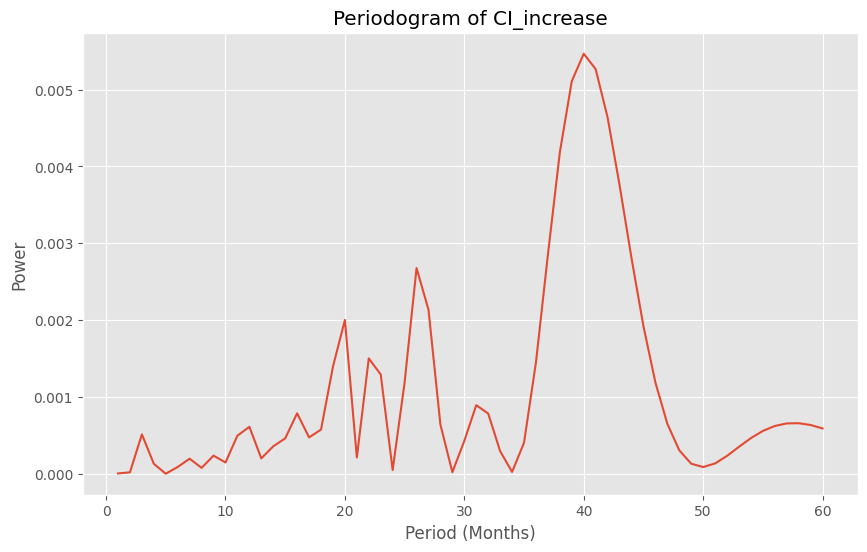

Estimated period length for CI_increase: 40 months with power 0.005465965636817502


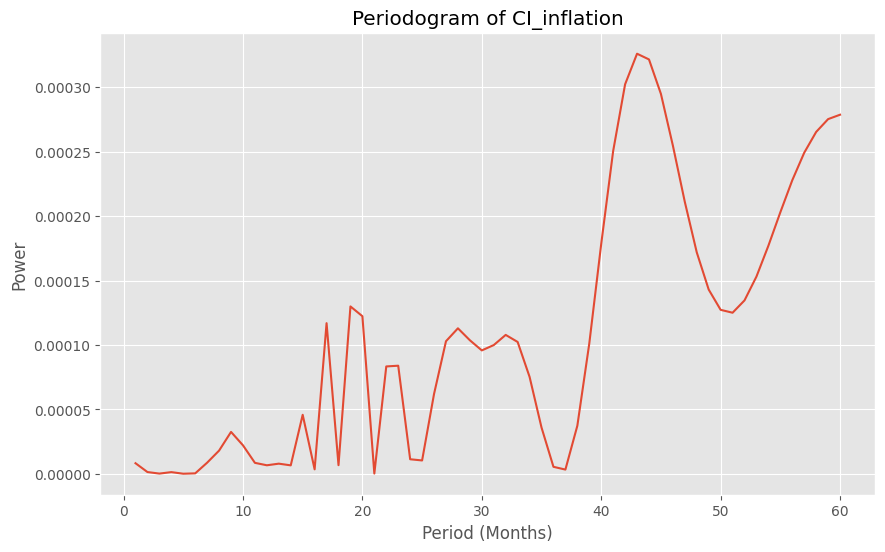

Estimated period length for CI_inflation: 43 months with power 0.00032596267743981237


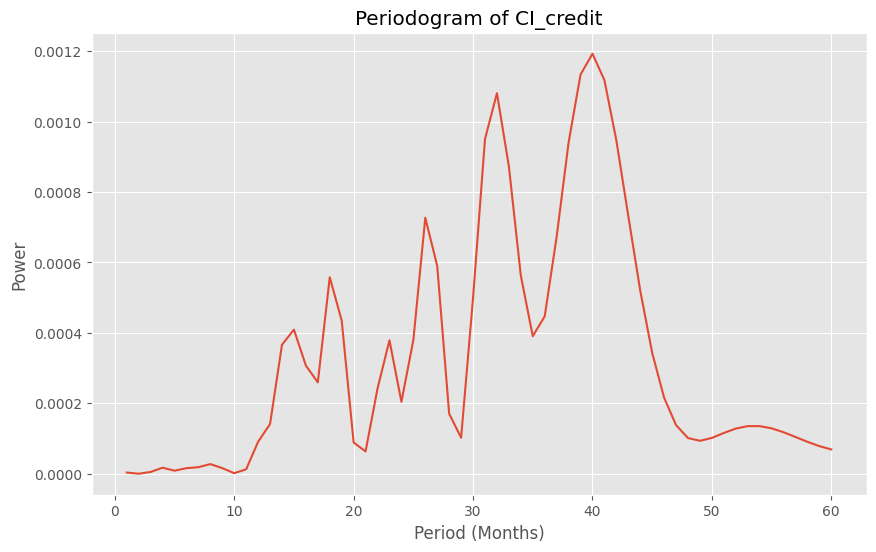

Estimated period length for CI_credit: 40 months with power 0.0011923943184815047


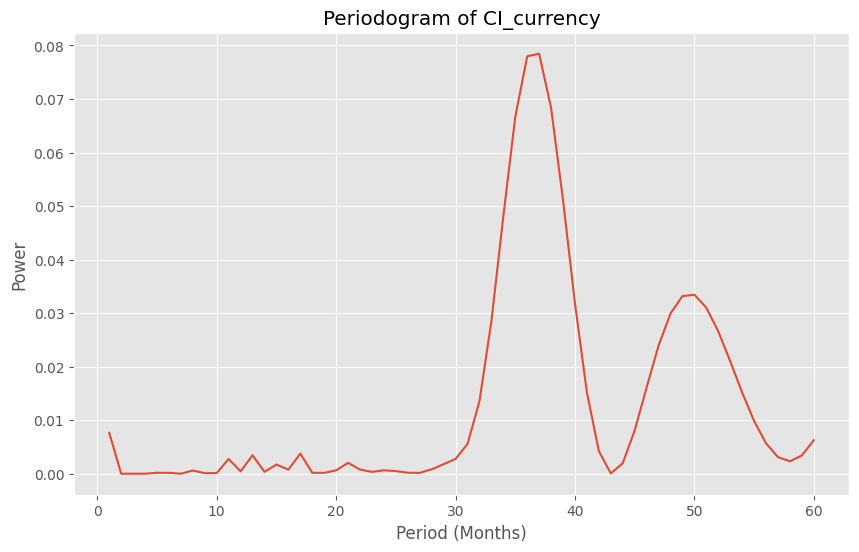

Estimated period length for CI_currency: 37 months with power 0.07845817608724395


In [45]:
# Call the function for each dataset and assign the result to specific variables
period_increase = int(period_analyse(CI_increase, "CI_increase"))
period_inflation = int(period_analyse(CI_inflation, "CI_inflation"))
period_credit = int(period_analyse(CI_credit, "CI_credit"))
period_currency = int(period_analyse(CI_currency, "CI_currency"))

## 正比例函数拟合基钦周期

In [46]:
#周期判断，用正比例函数拟合基钦周期
def f_fit(x,a,b,period):
    return a*np.sin((2*np.pi)*x/period + b)

def f_show(x,p_fit,period):
    a,b,period = p_fit.tolist()
    return a*np.sin((2*np.pi)*np.array(x)/period + b)

# 周期拟合效果

In [47]:
def plot_period(df, period):
    x = np.arange(len(df))
    y = df['Value'].values

    p_fit, pcov = curve_fit(f_fit, x, y, p0=[np.std(y), 0, period], maxfev=2000)
    
    plt.style.use('ggplot')
    plt.figure(figsize=(12, 9), dpi=350)
    
    # 绘制拟合曲线和原始数据
    plt.plot(df.index, df['Value'], label='Increase index',color = '#3366ff')
    plt.plot(df.index, f_show(x, p_fit, period), label='Fitted Period', color = 'red')
    
    
    plt.legend()
    plt.title('Increase index constructed by OECD method')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.show()

In [75]:
def plot_period(df, period,title):
    x = np.arange(len(df))
    y = df['Value'].values

    p_fit, pcov = curve_fit(f_fit, x, y, p0=[np.std(y), 0, period], maxfev=2000)
    
    # Create the original data trace
    trace1 = go.Scatter(
        x=df.index,
        y=df['Value'],
        mode='lines',
        name=title,
        line=dict(color='#3366ff')
    )

    # Create the fitted period trace
    trace2 = go.Scatter(
        x=df.index,
        y=f_show(x, p_fit, period),
        mode='lines',
        name='Fitted Period',
        line=dict(color='red')
    )

    # Create the figure with the traces
    fig = make_subplots()
    fig.add_trace(trace1)
    fig.add_trace(trace2)

    # Update the layout
    fig.update_layout(
        width=900,
        height=400,
        title=title,
        xaxis_title='Date',
        yaxis_title='Value',
        template='ggplot2'
    )

    # Show the figure
    fig.show()

In [76]:
CI_increase1 = pd.DataFrame(CI_increase)
CI_increase1.columns = ['Value']

CI_inflation1 = pd.DataFrame(CI_inflation)
CI_inflation1.columns = ['Value']

CI_credit1 = pd.DataFrame(CI_credit)
CI_credit1.columns = ['Value']

CI_currency1 = pd.DataFrame(CI_currency)
CI_currency1.columns = ['Value']

In [77]:
plot_period(CI_increase1, period_increase, 'Increase Index')
plot_period(CI_inflation1, period_inflation, 'Inflation Index')
plot_period(CI_credit1, period_credit, 'Credit Index')
plot_period(CI_currency1, period_currency, 'Currency Index')

## 未来周期预测

In [51]:
# 假设的拟合函数，您可以根据实际情况修改
def sinusoidal_fit(x, amplitude, phase, period):
    return amplitude * np.sin(2 * np.pi * x / period + phase)

# 展示函数，可以加上预测周期
def extended_sinusoidal(params, period, data_length, extend_month=0):
    x_extended = np.arange(data_length + extend_month)
    return sinusoidal_fit(x_extended, *params)

def plot_with_forecast(df, period, extend_month=36):
    x = np.arange(len(df))
    y = df['Value'].values

    p_fit, pcov = curve_fit(sinusoidal_fit, x, y, p0=[np.std(y), 0, period], maxfev=2000)

    return extended_sinusoidal(p_fit, period, len(y), extend_month)

In [52]:
# 预测未来周期
extend_month = 36
forecast_increase = plot_with_forecast(CI_increase1, period_increase, extend_month)
forecast_inflation = plot_with_forecast(CI_inflation1, period_inflation, extend_month)
forecast_credit = plot_with_forecast(CI_credit1, period_credit, extend_month)
forecast_currency = plot_with_forecast(CI_currency1, period_currency, extend_month)

In [78]:

# Calculate the max and min values of all forecasts
all_forecasts = forecast_increase + forecast_inflation + forecast_credit + forecast_currency
forecast_max = max(all_forecasts)
forecast_min = min(all_forecasts)

# Create date range for forecast
start_date = df.index[0]
end_date = df.index[-1] + pd.DateOffset(years=3)
date_rng = pd.date_range(start_date, end_date, freq='M')

# Helper function to calculate percentage position on sinusoidal curve
def calculate_percentage(value, min_value, max_value):
    return ((value - min_value) / (max_value - min_value)) * 100

# Create traces for each forecast
trace_increase = go.Scatter(
    x=date_rng,
    y=forecast_increase,
    mode='lines',
    name="Forecast Increase",
    line=dict(color='#ff1100'),
    hovertemplate='Date: %{x}<br>Value: %{y:.2f}<br>Position: %{customdata:.2f}%',
    customdata=[calculate_percentage(v, min(forecast_increase), max(forecast_increase)) for v in forecast_increase]
)

trace_inflation = go.Scatter(
    x=date_rng,
    y=forecast_inflation,
    mode='lines',
    name="Forecast Inflation",
    line=dict(color='#0e4f33'),
    hovertemplate='Date: %{x}<br>Value: %{y:.2f}<br>Position: %{customdata:.2f}%',
    customdata=[calculate_percentage(v, min(forecast_inflation), max(forecast_inflation)) for v in forecast_inflation]
)

trace_credit = go.Scatter(
    x=date_rng,
    y=forecast_credit,
    mode='lines',
    name="Forecast Credit",
    line=dict(color='purple'),
    hovertemplate='Date: %{x}<br>Value: %{y:.2f}<br>Position: %{customdata:.2f}%',
    customdata=[calculate_percentage(v, min(forecast_credit), max(forecast_credit)) for v in forecast_credit]
)

trace_currency = go.Scatter(
    x=date_rng,
    y=forecast_currency,
    mode='lines',
    name="Forecast Currency",
    line=dict(color='orange'),
    hovertemplate='Date: %{x}<br>Value: %{y:.2f}<br>Position: %{customdata:.2f}%',
    customdata=[calculate_percentage(v, min(forecast_currency), max(forecast_currency)) for v in forecast_currency]
)

# Create the figure and add traces
fig = make_subplots()
fig.add_trace(trace_increase)
fig.add_trace(trace_inflation)
fig.add_trace(trace_credit)
fig.add_trace(trace_currency)

# Add a vertical line to indicate the prediction start
fig.add_vline(x=df.index[-1], line_width=2, line_dash="dash", line_color="black")

# Update the layout
fig.update_layout(
    width=900,
    height=500,
    title='Combined Indices with Future Predictions',
    xaxis_title='Date',
    yaxis_title='Value',
    template='ggplot2'
)

# Show the figure
fig.show()

/var/folders/_r/4027ks1j3_l9nb5fytmkd7ch0000gn/T/ipykernel_22790/2170526678.py:9: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



# 大类资产配置回测

## 根据四类资产的周化波动率 进行资产权重配置

In [54]:
#根据风险预算模型计算不同风险占比下资产的配置权重
def cacu_weight(days, stock_r, bond_r, commodit_r, gold_r, b_w):
    df1 = pd.DataFrame(stock_r['stock'].tolist()[-days:],columns = ['stock'])
    df2 = pd.DataFrame(bond_r['bond'].tolist()[-days:],columns = ['bond'])
    df3 = pd.DataFrame(commodit_r['commodit'].tolist()[-days:],columns = ['commodit'])
    df4 = pd.DataFrame(gold_r['gold'].tolist()[-days:],columns = ['gold'])
    df_ = pd.concat([df1, df2, df3, df4], axis=1)
    df_.columns = ['stock', 'bond', 'commodit', 'gold']
    
    # Calculate week standard deviations (volatilities)
    week_vols = df_.std() * np.sqrt(days)
    
    # Unpack the volatilities
    sigma_s, sigma_b, sigma_c, sigma_g = week_vols['stock'], week_vols['bond'], week_vols['commodit'], week_vols['gold']
    #print(sigma_s, sigma_b, sigma_c, sigma_g)
    
    w1 = (sigma_s*b_w[1])/(sigma_b*b_w[0])
    w2 = (sigma_s*b_w[2])/(sigma_c*b_w[0])
    w3 = (sigma_s*b_w[3])/(sigma_g*b_w[0])
    sum = 1 + w1 + w2 + w3
    w = [1/sum, w1/sum, w2/sum, w3/sum]
    
    w_init = b_w.copy()
    for i in range(len(w_init)):
        w[i] = (w[i]*0.9 + w_init[i]*0.1)
    w = np.array(w) / np.sum(w)
    
    """
    w_init = b_w.copy()
    for i in range(len(w_init)):
        if w[i] > w_init[i] * 2:
            w[i] = w_init[i] * 2
        elif w[i] < w_init[i] * 0.5:
            w[i] = w_init[i] * 0.5
        w = np.array(w) / np.sum(w)
    """
    
    return w
    


## 周期相位判断

In [55]:
def periods(alist,period,finish):
    result = []
    a, b = finish - 4, finish
    w = 0.0 
    
    for i in range(a,b):
        x = np.arange(i)
        y = alist[-i:]
        #print(len(y))
        
        p_fit, pcov = curve_fit(f_fit, x, y, p0=[np.std(y), 0, period], maxfev=10000)
        threshold_ext = abs(p_fit[0] * np.sin(np.pi / 3))
        threshold_int = abs(p_fit[0] * np.sin(np.pi * 2 / 3))
        
        f_i = f_show(i + 1, p_fit, period)
        f_i_minus_1 = f_show(i, p_fit, period)

        w += 0.6
        #if i == b - 1:
            #w = 2
        w1 = 0.8 * w
        w2 = 0.6 * w
    
        if -threshold_int < f_i < threshold_int:
            if f_i > f_i_minus_1:
                result.append(w)
            elif f_i < f_i_minus_1:
                result.append(-w)
        
        elif -threshold_ext < f_i < threshold_ext:
            if f_i > f_i_minus_1:
                result.append(w1)
            elif f_i < f_i_minus_1:
                result.append(-w1)
                
        elif f_i >= threshold_ext:
            if y[-1] > y[-2]:
                result.append(w2)
            elif y[-1] < y[-2]:
                result.append(0)
                
        else:
            if y[-1] > y[-2]:
                result.append(0)
            elif y[-1] < y[-2]:
                result.append(-w2)
    if np.sum(result) == 0:
        return 0
    result_ = np.sum(np.array(result) / np.sum(result))
    result = result_
    return result

## 因子动量法

In [56]:
#动量判断
def momentum(alist):
    a = alist[-1] - alist[-2]
    b = alist[-2] - alist[-3]
    if a > 0 and b > 0:
        result = 6
    elif a > 0 and b == 0:
        result = 3
    elif a > 0 and b < 0:
        result = 1.5
    elif a == 0 and b > 0:
        result = 3
    elif a == 0 and b < 0:
        result = -3
    elif a < 0 and b < 0:
        result = -6
    elif a < 0 and b == 0:
        result = -3
    elif a < 0 and b > 0:
        result = -1.5
    else:
        result = 0
    return result

## 宏观环境预测 （周期与动量）

In [57]:
#对下一期宏观环境进行预测（周期与动量两个条件相结合）
def forecast(macro_name, macro_index, period, finish):
    result = []
    for i in range(finish,len(macro_index)):
        m = macro_index.iloc[:i,:]
        #print(m)
        a = periods(m[macro_name].tolist(), period, finish)
        b = momentum(m[macro_name].tolist())
        #c = (a * 0.382 + b * 0.618) / 6
        c = (a + b) / 12
        #c = a / 6
        #c = b / 6
        result.append(c)
    #print(len(result))
    return result

## 根据宏观环境 进行资产权重配置

In [58]:
def macro_weight(up, down):
    up1 = (up + 0.5) / 1.5
    down1 = (down + 0.5) / 1.5
    
    adjustments = [
        ([up,   down,  up,   1],   [down1, up,    down1, up1]),
        ([1,    down1, up,   up],  [1,     1,     down,  down]),
        ([up,   1,     up1,  up1], [down1, 1,     down1, down1]),
        ([1,    up1,   down, 1],   [1,     down1, up,    1])
    ]
    
    return adjustments

In [59]:
def risk_change(w, alist, up, down):
    #w_init = init_weight_base
    
    for i in range(len(w)):
        weight = alist[i]
        weight1 = (weight + 1.5) / 1.5
        
        if weight > 0:
            factor = macro_weight(up*weight1, down*weight1)[i][0]
        elif weight < 0:
            factor = macro_weight(up*weight1, down*weight1)[i][1]
        else:
            continue
        w = w * np.array(factor) / sum(w * np.array(factor))
        
    return w


## ERP的处理

In [60]:
def get_ERP(bar):
    bond_rate = w.edb('S0059749',beginning, end, "Fill=Previous;Days=Alldays",usedf = True)[1]
    PE = w.wsd("881001.WI", "pe_ttm", beginning, end, "ruleType=10;Days=Alldays",usedf = True)[1]
    df_ERP = 1/PE
    df_ERP = df_ERP.join(bond_rate)
    df_ERP['ERP'] = df_ERP['PE_TTM'] - df_ERP['close']
    #print(df_ERP)

    rank_bottom,rank_top = [],[]
    for i in range(42*20,len(df_ERP)):
        rank_bottom.append(np.percentile(df_ERP['ERP'].iloc[i-42*20:i], bar))
        rank_top.append(np.percentile(df_ERP['ERP'].iloc[i-42*20:i], 100-bar))
    
    df_ERP = pd.concat([df_ERP['ERP'].iloc[42*20:],pd.DataFrame(rank_bottom,index = df_ERP['ERP'].iloc[42*20:].index),pd.DataFrame(rank_top,index = df_ERP['ERP'].iloc[42*20:].index)],axis = 1)
    df_ERP.columns = ['ERP','rank_bottom','rank_top']
    #print(df_ERP)
     
    df_ERP = df_ERP.dropna()
    df_ERP['date'] = pd.to_datetime(df_ERP.index)
    df_ERP.set_index('date', inplace=True)
    df_ERP = df_ERP.resample('ME').mean()
    df_ERP.index = pd.to_datetime(df_ERP.index)
    
    return df_ERP

## 数据整合

In [94]:
macro_index = df[['increase','inflation','credit','currency']]
market_index = df[['stock','bond','commodit','gold']]
#print(df.index)

finish = 60

increase_pre = forecast('increase', macro_index, period_increase, finish)
inflation_pre = forecast('inflation', macro_index, period_inflation, finish)
credit_pre = forecast('credit', macro_index, period_credit, finish)
currency_pre = forecast('currency', macro_index, period_currency, finish) #list(np.array(forecast('currency', macro_index, period_currency, finish))*(-1))
#print(len(increase_pre))

df_result = pd.concat([pd.DataFrame(increase_pre),pd.DataFrame(inflation_pre),pd.DataFrame(credit_pre),pd.DataFrame(currency_pre)],axis = 1)
df_result.columns = ['increase_pre','inflation_pre','credit_pre','currency_pre']
df_result.index = macro_index.index[finish:] #pd.date_range(beginning,periods = len(df_result), freq="ME")
#print(df_result.index)

## 四类资产的回报率

In [95]:
stock_r = w.wsd("881001.WI", "close", beginning, end, "Period=D",usedf = True)[1].pct_change(periods = 1).dropna()
stock_r.columns = ['stock']

bond_r = w.wsd("CBA00101.CS", "close", beginning, end, "Period=D",usedf = True)[1].pct_change(periods = 1).dropna()
bond_r.columns = ['bond']

commodit_r = w.wsd("NH0100.NHF", "close", beginning, end, "Period=D",usedf = True)[1].pct_change(periods = 1).dropna()
commodit_r.columns = ['commodit']

gold_r = w.wsd("AU9999.SGE", "close", beginning, end, "Period=D",usedf = True)[1].pct_change(periods = 1).dropna()
gold_r.columns = ['gold']

#M;Days=Alldays

stock_r['date'] = pd.to_datetime(stock_r.index)
bond_r['date'] = pd.to_datetime(bond_r.index)
commodit_r['date'] = pd.to_datetime(commodit_r.index)
gold_r['date'] = pd.to_datetime(gold_r.index)
#print(stock_r)

In [96]:
df_backtest = df_result.join(market_index).dropna()
#print(df_result)

df_backtest = df_backtest.iloc[:]
df_backtest.index = pd.to_datetime(df_backtest.index)
df_backtest['date'] = df_backtest.index
date_index = df_backtest.index
#print(df_backtest)

In [97]:
date_index = date_index[:]
print(date_index)

DatetimeIndex(['2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30',
               '2014-05-31', '2014-06-30', '2014-07-31', '2014-08-31',
               '2014-09-30', '2014-10-31',
               ...
               '2023-09-30', '2023-10-31', '2023-11-30', '2023-12-31',
               '2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30'],
              dtype='datetime64[ns]', length=126, freq=None)


# 最终回测函数

## 回测结果计算

In [98]:
#回测结果函数
def result_fun(return_list, rate_list):
    result = []
    i = np.argmax((np.maximum.accumulate(return_list)- return_list)/np.maximum.accumulate(return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])    
    MaxDrawdown = -(return_list[j] - return_list[i]) / return_list[j]
    return_year = pow(return_list[-1],12/len(return_list))-1
    volatility = np.std(np.array(rate_list)-1) * np.sqrt(12)
    
    result.append(return_list[-1])
    result.append(return_year*100)
    result.append(volatility*100)
    result.append(MaxDrawdown*100)
    result.append((return_year-0.03)/volatility)    
    result = pd.DataFrame(result).T
    result.columns = ['Net value','Annualized return %','Volatility %','Max Drawdown%','Sharpe Ratio']    
    
    return result

In [99]:
def test(init_weight_base, erp_bar, up, down,days):
    b_w = init_weight_base
    b_w1 = init_weight_base
    b_w2 = init_weight_base
    b_w3 = init_weight_base
    
    df_ERP = get_ERP(erp_bar).iloc[:]
    df_ERP.index = pd.to_datetime(df_ERP.index)
    df_ERP['date'] = df_ERP.index
    
    for i in trange(len(date_index)):
        d = df_backtest[df_backtest['date'] == date_index[i]]
        ERP = df_ERP[df_ERP['date'] == date_index[i]]
        
        b_w = init_weight_base
        b_w1 = init_weight_base
        b_w3 = init_weight_base
        
        up1 = (up + 0.5) / 1.5
        down1 = (down + 0.5) / 1.5
        
        if ERP.ERP.tolist()[0] < ERP.rank_bottom.tolist()[0]:
            b_w = np.array([down1,up1,1,1])*b_w / sum(np.array([down1,up1,1,1])*b_w)
        elif ERP.ERP.tolist()[0] > ERP.rank_top.tolist()[0]:
            b_w = np.array([up1,down1,1,1])*b_w / sum(np.array([up1,down1,1,1])*b_w)
        
        b_w = risk_change(b_w,d.iloc[:,:4].values[0].tolist(),up,down)
        b_w1 = risk_change(b_w1,d.iloc[:,:4].values[0].tolist(),up,down)
        b_w3 = risk_change(b_w3,d.iloc[:,:4].values[0].tolist(),up,down)
        
        #print(b_w)
        
        stock_input = stock_r[stock_r['date'] < date_index[i]]
        bond_input = bond_r[bond_r['date'] < date_index[i]]
        commodit_input = commodit_r[commodit_r['date'] < date_index[i]]
        gold_input = gold_r[gold_r['date'] < date_index[i]]
        
        weight_me = cacu_weight(days, stock_input,bond_input,commodit_input, gold_input, b_w)
        weight_noerp = cacu_weight(days, stock_input,bond_input,commodit_input, gold_input, b_w1)
        b_w2 = cacu_weight(days, stock_input,bond_input,commodit_input, gold_input, b_w2)
        weight_baseline = init_weight_base
        weigth_clock = b_w3
        
        rate_me.append(sum(np.array(weight_me)*(d.iloc[:,4:-1].values[0] + 1)))
        rate_noerp.append(sum(np.array(weight_noerp)*(d.iloc[:,4:-1].values[0] + 1)))
        rate_risk.append(sum(np.array(b_w2)*(d.iloc[:,4:-1].values[0] + 1)))
        rate_clock.append(sum(np.array(weigth_clock)*(d.iloc[:,4:-1].values[0] + 1)))
        rate_base.append(sum(np.array(weight_baseline)*(d.iloc[:,4:-1].values[0] + 1)))
        
        change_me.append(weight_me)
        change_noerp.append(weight_noerp)
        change_base.append(weight_baseline)
        change_risk.append(b_w2)
        change_clock.append(weigth_clock)

## 回测结果展示

In [100]:
rate_me = []
rate_base = []
rate_noerp = []
rate_risk = []
rate_clock = []

change_me = []
change_base = []
change_noerp = []
change_risk = []
change_clock = []

#test(init_weight_base,         , erp, up,  down, assets_vol_days,)
test( [0.3,0.3,0.2,0.2], 18, 1.3, 0.6,  5)

100%|██████████| 126/126 [00:01<00:00, 103.71it/s]


In [113]:
# 计算累积乘积
value_me = pd.DataFrame(rate_me).cumprod()
value_noerp = pd.DataFrame(rate_noerp).cumprod()
value_base = pd.DataFrame(rate_base).cumprod()
value_risk = pd.DataFrame(rate_risk).cumprod()
value_clock = pd.DataFrame(rate_clock).cumprod()

# 设置索引
value_me.index = date_index
value_noerp.index = date_index
value_base.index = date_index
value_risk.index = date_index
value_clock.index = date_index

# Reset index to use date as a column for the bar chart
change_me1 = pd.DataFrame(change_me)
change_me1.index = date_index
change_me1.columns = ['stock','bond','commodit','gold']
change_me1.reset_index(inplace=True)
change_me1.rename(columns={'index': 'Date'}, inplace=True)


result_me = result_fun(value_me[0].tolist(), rate_me)
result_noerp = result_fun(value_noerp[0].tolist(), rate_noerp)
result_base = result_fun(value_base[0].tolist(), rate_base)
result_risk = result_fun(value_risk[0].tolist(), rate_risk)
result_clock = result_fun(value_clock[0].tolist(), rate_clock)

# Assign indices
result_me.index = ['Strategy']
result_noerp.index = ['No ERP']
result_base.index = ['Benchmark']
result_risk.index = ['Risk only']
result_clock.index = ['Clock only']

# Concatenate results
result = pd.concat([result_me, result_noerp, result_base, result_risk, result_clock])

# Reorder indices
result = result.reindex(['Strategy', 'No ERP', 'Clock only', 'Risk only', 'Benchmark'])

# 创建子图布局
fig = make_subplots(
    rows=3, cols=1,
    shared_xaxes=True,
    vertical_spacing=0.06,  # 减少子图之间的空白
    row_heights=[0.5, 0.2, 0.3],
    specs=[[{"type": "xy"}], [{"type": "xy"}], [{"type": "table"}]],
    subplot_titles=('Net value of different methods', 'Weight of 4 assets Over Time (Strategy)', ' ')
)

# 添加净值图形的轨迹
fig.add_trace(go.Scatter(
    x=value_base.index, y=value_base[0], mode='lines', name='benchmark', line=dict(color='black'),
    hovertemplate='%{y:.2f}<extra></extra>'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=value_risk.index, y=value_risk[0], mode='lines', name='risk', line=dict(color='orange'),
    hovertemplate='%{y:.2f}<extra></extra>'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=value_clock.index, y=value_clock[0], mode='lines', name='clock', line=dict(color='#114eff'),
    hovertemplate='%{y:.2f}<extra></extra>'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=value_noerp.index, y=value_noerp[0], mode='lines', name='no erp', line=dict(color='green'),
    hovertemplate='%{y:.2f}<extra></extra>'
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=value_me.index, y=value_me[0], mode='lines', name='strategy', line=dict(color='red'),
    hovertemplate='%{y:.2f}<extra></extra>'
), row=1, col=1)

# 添加堆叠条形图的轨迹
fig.add_trace(go.Bar(
    x=change_me1['Date'],
    y=change_me1['stock'],
    name='Stock',
    marker_color='red',
    hovertemplate='Stock: %{y:.2f}<extra></extra>'
), row=2, col=1)

fig.add_trace(go.Bar(
    x=change_me1['Date'],
    y=change_me1['bond'],
    name='Bonds',
    marker_color='green',
    hovertemplate='Bonds: %{y:.2f}<extra></extra>'
), row=2, col=1)

fig.add_trace(go.Bar(
    x=change_me1['Date'],
    y=change_me1['commodit'],
    name='Commodities',
    marker_color='orange',
    hovertemplate='Commodities: %{y:.2f}<extra></extra>'
), row=2, col=1)

fig.add_trace(go.Bar(
    x=change_me1['Date'],
    y=change_me1['gold'],
    name='Gold',
    marker_color='#114eff',
    hovertemplate='Gold: %{y:.2f}<extra></extra>'
), row=2, col=1)

# Assuming result is your DataFrame
formatted_values = [[f"{value:.2f}" for value in result[col]] for col in result.columns]

# Adding indices as the first column
indices = result.index.tolist()
formatted_values.insert(0, indices)

# Adding 'Index' as the first header value
header_values = ["<b>Index</b>"] + ["<b>{}</b>".format(col) for col in result.columns]

fig.add_trace(
    go.Table(
        header=dict(
            values=header_values,
            font=dict(size=12),
            align="left"
        ),
        cells=dict(
            values=formatted_values,
            align="left"
        )
    ), row=3, col=1
)

# 更新布局以更好地显示
fig.update_layout(
    width=900,
    height=800,
    barmode='stack',
    template='plotly_white',
    hovermode='x unified',  # 鼠标悬停模式，显示所有轨迹的值
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Rockwell"
    )
)

fig.update_yaxes(gridcolor='lightgray')  # Add gridlines

# Show the figure in high resolution
fig.show()

# Save the figure as a html file
html_combined = "/Users/chenxinghe/Desktop/实习/Report/Poster/combined_graph.html"

fig.write_html(html_combined)


## 结果计算

In [102]:
result_stock = result_fun((df_backtest['stock']+1).cumprod().tolist(),df_backtest['stock'].tolist())
result_bond = result_fun((df_backtest['bond']+1).cumprod().tolist(),df_backtest['bond'].tolist())
result_commodit = result_fun((df_backtest['commodit']+1).cumprod().tolist(),df_backtest['commodit'].tolist())
result_gold = result_fun((df_backtest['gold']+1).cumprod().tolist(),df_backtest['gold'].tolist())

result1 = pd.concat([result_stock, result_bond, result_commodit, result_gold])
result1.index = ['Stock','Bond','Commodities','Gold']
result1

,Net value,Annualized return %,Volatility %,Max Drawdown%,Sharpe Ratio
Stock,1.791392,5.709345,23.232108,-48.443917,0.116621
Bond,1.675890,5.040483,1.987820,-3.229952,1.026493
Commodities,2.191476,7.758397,15.537340,-28.971761,0.306256
Gold,2.325467,8.369167,12.190697,-17.455182,0.440432


In [103]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
#change_me

# 优化 

In [104]:
# 定义年化收益率和夏普比率计算函数
def calculate_annualized_return(returns):
    compounded_growth = (1 + returns).prod()
    n_periods = returns.shape[0]
    return compounded_growth ** (12 / n_periods) - 1

def calculate_sharpe_ratio(returns, risk_free_rate=0.03):
    excess_returns = returns - risk_free_rate / 12
    return np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(12)

In [105]:
import numpy as np
import pandas as pd
from itertools import product

"""

def generate_risk_combinations(step=0.1):
    #Generate all possible risk weight combinations with a given step size.
    weights = np.arange(0.1, 1 + step, step)
    combinations = [list(comb) for comb in product(weights, repeat=4) if np.isclose(sum(comb), 1)]
    print(len(combinations))
    return combinations

# 定义回测结果函数
def result_fun(return_list, rate_list):
    result = []
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])
    MaxDrawdown = -(return_list[j] - return_list[i]) / return_list[j]
    return_year = pow(return_list[-1], 12 / len(return_list)) - 1
    volatility = np.std(rate_list) * np.sqrt(12)
    
    result.append(return_list[-1])
    result.append(return_year * 100)
    result.append(volatility * 100)
    result.append(MaxDrawdown * 100)
    result.append((return_year - 0.03) / volatility)
    result = pd.DataFrame(result).T
    result.columns = ['Net value', 'Annualized return %', 'Volatility %', 'Max Drawdown%', 'Sharpe Ratio']
    
    return result

# 生成所有可能的风险权重组合
risk_combinations = generate_risk_combinations()

# 结果总结
results_summary = []

for risk_base in risk_combinations:
    rate_me = []
    rate_base = []
    rate_noerp = []
    rate_risk = []
    rate_clock = []

    change_me = []
    change_base = []
    change_noerp = []
    change_risk = []
    change_clock = []

    # 假设 date_index 和其他数据已经准备好
    test(risk_base, 18, 1.3, 0.6, 5)
            
    value_me = pd.DataFrame(rate_me).cumprod()
    value_noerp = pd.DataFrame(rate_noerp).cumprod()
    value_base = pd.DataFrame(rate_base).cumprod()
    value_risk = pd.DataFrame(rate_risk).cumprod()
    value_clock = pd.DataFrame(rate_clock).cumprod()

    value_me.index = date_index
    value_noerp.index = date_index
    value_base.index = date_index
    value_risk.index = date_index
    value_clock.index = date_index
    
    # 计算年化收益率和夏普比率
    annualized_return = pow(value_me[0].tolist()[-1], 12 / len(value_me[0].tolist())) - 1
    sharpe_ratio = calculate_sharpe_ratio(value_me.pct_change().dropna())
    
    # 收集结果
    results_summary.append({
        'Risk Base': risk_base,
        'Annualized Return': annualized_return,
        'Sharpe Ratio': sharpe_ratio
    })

results_df = pd.DataFrame(results_summary)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
results_df
"""

"\n\ndef generate_risk_combinations(step=0.1):\n    #Generate all possible risk weight combinations with a given step size.\n    weights = np.arange(0.1, 1 + step, step)\n    combinations = [list(comb) for comb in product(weights, repeat=4) if np.isclose(sum(comb), 1)]\n    print(len(combinations))\n    return combinations\n\n# 定义回测结果函数\ndef result_fun(return_list, rate_list):\n    result = []\n    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))\n    if i == 0:\n        return 0\n    j = np.argmax(return_list[:i])\n    MaxDrawdown = -(return_list[j] - return_list[i]) / return_list[j]\n    return_year = pow(return_list[-1], 12 / len(return_list)) - 1\n    volatility = np.std(rate_list) * np.sqrt(12)\n    \n    result.append(return_list[-1])\n    result.append(return_year * 100)\n    result.append(volatility * 100)\n    result.append(MaxDrawdown * 100)\n    result.append((return_year - 0.03) / volatility)\n    result = pd.DataFrame(r

## ERP的选取

In [106]:
"""
results_summary = []
for up in np.arange(1.3,1.4,0.1):
    for erp in range(5,23,1):
        rate_me = []
        rate_base = []
        rate_noerp = []
        rate_risk = []
        rate_clock = []

        change_me = []
        change_base = []
        change_noerp = []
        change_risk = []
        change_clock = []

        test([0.3, 0.3, 0.2, 0.2], erp, up, 0.6, 5)
                
        value_me = pd.DataFrame(rate_me).cumprod()
        value_noerp = pd.DataFrame(rate_noerp).cumprod()
        value_base = pd.DataFrame(rate_base).cumprod()
        value_risk = pd.DataFrame(rate_risk).cumprod()
        value_clock = pd.DataFrame(rate_clock).cumprod()

        value_me.index = date_index
        value_noerp.index = date_index
        value_base.index = date_index
        value_risk.index = date_index
        value_clock.index = date_index
        
        # 计算年化收益率和夏普比率
        annualized_return = pow(value_me[0].tolist()[-1],12/len(value_me[0].tolist()))-1
        #annualized_return = calculate_annualized_return(value_me.pct_change().dropna())
        sharpe_ratio = calculate_sharpe_ratio(value_me.pct_change().dropna())
        
        # 收集结果
        results_summary.append({
            'erp': erp,
            '年化收益率': annualized_return,
            '夏普比率': sharpe_ratio
        })
    
results_df = pd.DataFrame(results_summary)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
results_df
"""

"\nresults_summary = []\nfor up in np.arange(1.3,1.4,0.1):\n    for erp in range(5,23,1):\n        rate_me = []\n        rate_base = []\n        rate_noerp = []\n        rate_risk = []\n        rate_clock = []\n\n        change_me = []\n        change_base = []\n        change_noerp = []\n        change_risk = []\n        change_clock = []\n\n        test([0.3, 0.3, 0.2, 0.2], erp, up, 0.6, 5)\n                \n        value_me = pd.DataFrame(rate_me).cumprod()\n        value_noerp = pd.DataFrame(rate_noerp).cumprod()\n        value_base = pd.DataFrame(rate_base).cumprod()\n        value_risk = pd.DataFrame(rate_risk).cumprod()\n        value_clock = pd.DataFrame(rate_clock).cumprod()\n\n        value_me.index = date_index\n        value_noerp.index = date_index\n        value_base.index = date_index\n        value_risk.index = date_index\n        value_clock.index = date_index\n        \n        # 计算年化收益率和夏普比率\n        annualized_return = pow(value_me[0].tolist()[-1],12/len(value_me[

## 各个因子中的指标选取

In [107]:
from itertools import combinations
"""
# 定义因子列表
ID_code_list = [ID_code_inflation]#[ID_code_increase, ID_code_inflation, ID_code_credit, ID_code_currency]
ID_name_list = [ID_name_inflation]#[ID_name_increase, ID_name_inflation, ID_name_credit, ID_name_currency]

CI_increase1 = CI_increase.copy()
CI_inflation1 = CI_inflation.copy()
CI_credit1 = CI_credit.copy()
CI_currency1 = CI_currency.copy()

# 定义要去掉的指标数目范围 (例如,去掉1到3个指标)
remove_counts = [1]

results_summary = []

# 逐个去掉每个因子中的多个指标并进行回测
for factor_codes, factor_names in zip(ID_code_list, ID_name_list):
    for remove_count in remove_counts:
        for combo in combinations(range(len(factor_codes)), remove_count):
            CI_increase = CI_increase1.copy()
            CI_inflation = CI_inflation1.copy()
            CI_credit = CI_credit1.copy()
            CI_currency = CI_currency1.copy()
            
            temp_codes = [code for i, code in enumerate(factor_codes) if i not in combo]
            temp_names = [name for i, name in enumerate(factor_names) if i not in combo]
            
            result = data_treatment(temp_codes, temp_names)
            result_ = result.iloc[12:,:]
            S = OECD(result_)
            
            if factor_codes == ID_code_list[0]:
                X = inflation.iloc[12:,:]
                we = '通胀'
            elif factor_codes == ID_code_list[3]:
                X = PMI.iloc[12:,:]
                we = '增长'
            elif factor_codes == ID_code_list[2]:
                X = credit.iloc[12:,:]
                we = '信用'
            elif factor_codes == ID_code_list[3]:
                X = currency.iloc[12:,:]
                we = '货币'
                
            k = abs(X - X.mean()).sum().iloc[0] / abs(S - S.mean()).sum()
            d = X.mean().iloc[0] - S.mean()
            CI_temp = k * S + d
            
            if factor_codes == ID_code_list[0]:
                CI_inflation = CI_temp
            elif factor_codes == ID_code_list[3]:
                CI_increase = CI_temp
            elif factor_codes == ID_code_list[2]:
                CI_credit = CI_temp
            elif factor_codes == ID_code_list[3]:
                CI_currency = CI_temp
            
            macro_fac = pd.DataFrame([CI_increase, CI_inflation, CI_credit, CI_currency]).T
            macro_fac.columns = ['increase', 'inflation', 'credit', 'currency']

            df = pd.concat([macro_fac, stock, bond, commodit, gold], axis=1).dropna()
            df['date'] = pd.to_datetime(df.index)

            period_increase = int(period_analyse(CI_increase, "CI_increase"))
            period_inflation = int(period_analyse(CI_inflation, "CI_inflation"))
            period_credit = int(period_analyse(CI_credit, "CI_credit"))
            period_currency = int(period_analyse(CI_currency, "CI_currency"))

            macro_index = df[['increase', 'inflation', 'credit', 'currency']]
            market_index = df[['stock', 'bond', 'commodit', 'gold']]
            
            finish = 56

            increase_pre = forecast('increase', macro_index, period_increase, finish)
            inflation_pre = forecast('inflation', macro_index, period_inflation, finish)
            credit_pre = forecast('credit', macro_index, period_credit, finish)
            currency_pre = forecast('currency', macro_index, period_currency, finish)

            df_result = pd.concat([pd.DataFrame(increase_pre), pd.DataFrame(inflation_pre), pd.DataFrame(credit_pre), pd.DataFrame(currency_pre)], axis=1)
            df_result.columns = ['increase_pre', 'inflation_pre', 'credit_pre', 'currency_pre']
            df_result.index = macro_index.index[finish:]

            df_backtest = df_result.join(market_index).dropna()

            df_backtest = df_backtest.iloc[3:]
            df_backtest.index = pd.to_datetime(df_backtest.index)
            df_backtest['date'] = df_backtest.index
            date_index = df_backtest.index

            # 初始化回测参数
            date_index = df_backtest['date'].unique()

            rate_me = []
            rate_base = []
            rate_noerp = []
            rate_risk = []
            rate_clock = []

            change_me = []
            change_base = []
            change_noerp = []
            change_risk = []
            change_clock = []

            # 执行回测
            test([0.45, 0.3, 0.24, 0.01], 23, 1.4, 0.6, 5)
            
            value_me = pd.DataFrame(rate_me).cumprod()
            value_noerp = pd.DataFrame(rate_noerp).cumprod()
            value_base = pd.DataFrame(rate_base).cumprod()
            value_risk = pd.DataFrame(rate_risk).cumprod()
            value_clock = pd.DataFrame(rate_clock).cumprod()

            value_me.index = date_index
            value_noerp.index = date_index
            value_base.index = date_index
            value_risk.index = date_index
            value_clock.index = date_index
            
            # 计算年化收益率和夏普比率
            annualized_return = calculate_annualized_return(value_me.pct_change().dropna())
            sharpe_ratio = calculate_sharpe_ratio(value_me.pct_change().dropna())
            
            remove_names = [name for i, name in enumerate(factor_names) if i in combo]
            
            # 收集结果
            results_summary.append({
                '因子': we,
                '去掉的指标': remove_names,
                '年化收益率': annualized_return,
                '夏普比率': sharpe_ratio
            })

# 转换结果为DataFrame并展示
results_df = pd.DataFrame(results_summary)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
results_df
"""

'\n# 定义因子列表\nID_code_list = [ID_code_inflation]#[ID_code_increase, ID_code_inflation, ID_code_credit, ID_code_currency]\nID_name_list = [ID_name_inflation]#[ID_name_increase, ID_name_inflation, ID_name_credit, ID_name_currency]\n\nCI_increase1 = CI_increase.copy()\nCI_inflation1 = CI_inflation.copy()\nCI_credit1 = CI_credit.copy()\nCI_currency1 = CI_currency.copy()\n\n# 定义要去掉的指标数目范围 (例如,去掉1到3个指标)\nremove_counts = [1]\n\nresults_summary = []\n\n# 逐个去掉每个因子中的多个指标并进行回测\nfor factor_codes, factor_names in zip(ID_code_list, ID_name_list):\n    for remove_count in remove_counts:\n        for combo in combinations(range(len(factor_codes)), remove_count):\n            CI_increase = CI_increase1.copy()\n            CI_inflation = CI_inflation1.copy()\n            CI_credit = CI_credit1.copy()\n            CI_currency = CI_currency1.copy()\n            \n            temp_codes = [code for i, code in enumerate(factor_codes) if i not in combo]\n            temp_names = [name for i, name in enumerate